## Introduction

1. We create N regularly spaced points (beads) on the [0,1] interval.
- Their labels are alternating between +1 and -1.

- To simplify the problem we assume that N is even.

2. We "thread the beads":
- The feature map is created. The feature map takes the beads locations and maps them on one qubit.
    The feature map consists of Hadamard layer, followed by a parameterized Z-rotation, followed by Hadamard layer.

    First Hadamard layer, moves the initial state |0> to a |+> state, which resides on the bloch sphere equator.

    The parameterized Z-rotation moves the beads around the equator. The rotation angle is defined as: (location of the bead)*(phi), where phi is the customizable parameter.

    Second Hadamard layer transformes the states into the computational basis.

- The ideal feature map will send all the +1 class beads to one (ex. |0>) pole of the bloch sphere and all the -1 class beads to the other pole.

    In the ideal feature map each positive class bead is rotated to |+> (|->) state, while the negative class beads are rotated to |-> (|+>) states.
    
    To achieve that the ideal map parameter value would be phi_ideal = (N-1)*np.pi (and its odd multiplicities).

3. We optimize the map parameter with respect to target kernel alignment and see whether we obtain the ideal feature map.

## Imports

In [1]:
import pandas as pd
#from pennylane 
import numpy as np
import matplotlib.pyplot as plt

import copy

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA

from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit import Parameter

from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 20

## Functions

In [68]:
def qubit_map(phi): #feature map
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.p(phi, 0)
    qc.h(0)
    return(qc)

def kernel_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    phi = Parameter('Φ')
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.p(phi*x1, 0)
    qc.p(-1.0*phi*x2,0)
    qc.h(0)
    qc.measure(0, 0)
    return(x1, x2, phi, qc)

def get_kernel_entry(qc, x1, x1_value, x2, x2_value, phi, phi_value, sim = Aer.get_backend('aer_simulator')):
    qc_bound = qc.bind_parameters({x1:float(x1_value), x2:float(x2_value), phi:float(phi_value)})
    qobj = assemble(qc_bound)  # Assemble circuit into a Qobj that can be run
    counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
    if(counts.get('0')):
        kernel_element = counts.get('0')/(sum(counts[item] for item in counts))
    else:
        kernel_element = 0
    return(kernel_element)


def get_kernel(x, phi_value):
    x1, x2, phi, qc_out = kernel_map()
    #return(qc_out.draw(output='mpl'))
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = get_kernel_entry(qc= qc_out, x1= x1, x1_value= x1_value, x2= x2, x2_value= x2_value, phi= phi, phi_value = phi_value)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)


def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

def loss(phi_val):
    return( - matrix_target_alignment(get_kernel(x, phi_val), y))

class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

def kernel_2_list(K):
  l = []
  n = K.shape[0]
  for i in range(n):
    for j in range(i):
      l.append(K[j,i])
  return(l)

def kernel_2_list_old(K):
  K = np.triu(K, k = 1)
  return(K[K != 0])

def replace_better_callback(cb_qkt_new, cb_qkt_old):
  if(cb_qkt_new[2][-1] < cb_qkt_old[2][-1]):
    #print('new callback is better!')
    return(cb_qkt_new)
  else:
    #print('old callback is better!')
    return(cb_qkt_old)

def run_SPSA_optimizations(runs = 10, max_init=100, maxiter = 20, learning_rate = 10.0, perturbation = 1.0, show_parameter_evolution = False, show_loss_evolution = False):
  for i in range(runs):
    cb_qkt = QKTCallback()
    initial_point = [max_init*np.random.rand()]
    spsa = SPSA(maxiter=maxiter, callback=cb_qkt.callback, learning_rate=learning_rate, perturbation=perturbation)
    result = spsa.optimize(1, loss, initial_point=initial_point)
    callback = cb_qkt.get_callback_data()

    if(show_parameter_evolution):
        print(callback[0])
        plt.plot(callback[0], callback[1], c="k", marker="o")
        plt.xlabel("Iteration")
        plt.ylabel("Parameter Value")
        plt.show()
        #plt.clf() 

    if(show_loss_evolution):
        plt.plot(callback[0], callback[2], c="k", marker="o")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
    
    if(i==0): best_callback = copy.deepcopy(callback)
    best_callback = copy.deepcopy(replace_better_callback(callback, best_callback))
    print('initial_point: ', initial_point)
    print('end loss: ', callback[2][-1])
    print('--------------------------------')
  print('Best loss: ', best_callback[2][-1])
  return(best_callback)

def get_best_parameter(callback):
    return(callback[1][-1])

## Setup

In [3]:
N = 8
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)
ideal_phi = (N-1)*np.pi

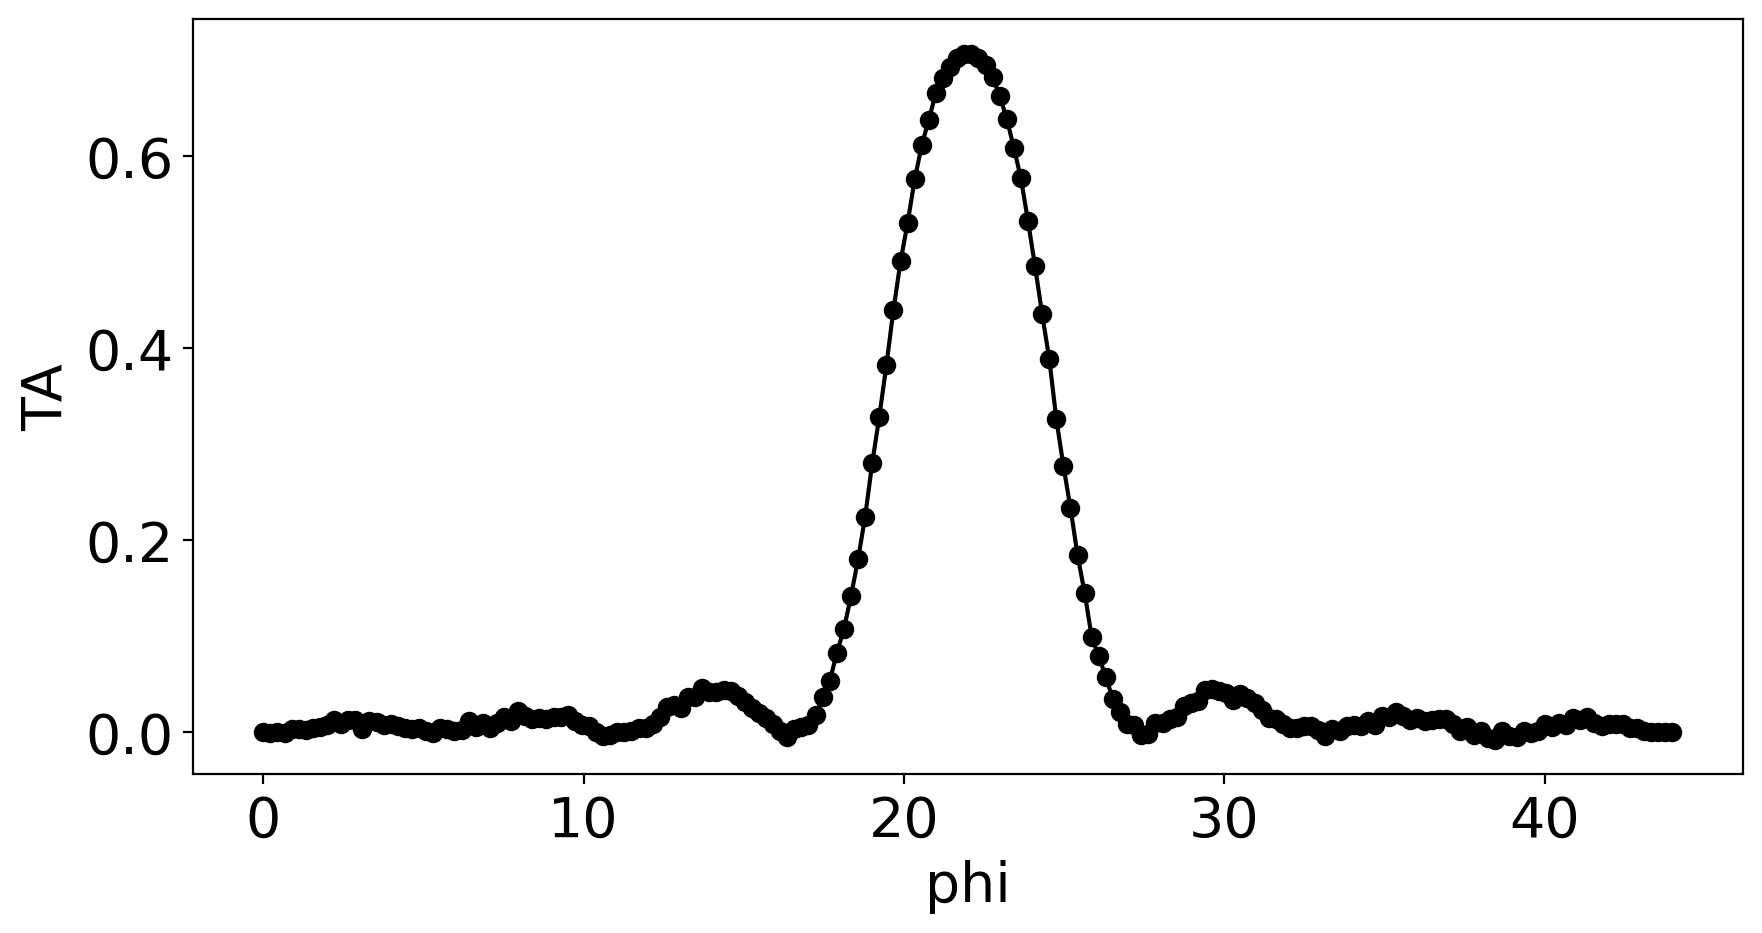

In [4]:
startpoint = 0
endpoint = 2*ideal_phi
points_number = 200
param_space = np.linspace(startpoint,endpoint, points_number)

Target_a = []
for item in param_space:
    Target_a.append(-loss(item))

plt.plot(param_space, Target_a, c="k", marker="o")
plt.xlabel("phi")
plt.ylabel("TA")
plt.show()

# SPSA

In [41]:
cb_qkt = QKTCallback()
initial_point = [0.85*ideal_phi]
#spsa = SPSA(maxiter=20, callback=cb_qkt.callback, learning_rate=10.0, perturbation=1.0)
spsa = SPSA(maxiter=50, callback=cb_qkt.callback)
#result = spsa.optimize(1, loss, initial_point=initial_point)
result = spsa.minimize(loss, x0=initial_point)

In [42]:
callback = cb_qkt.get_callback_data()
TA = callback[2]
param = callback[1]
initial_param = initial_point
end_param = param[-1][0]

In [43]:
print("Starting parameter: ", initial_point[0], "\nEnd parameter: ", param[-1][0], "\nIdeal value: ", np.pi*N, "\nLoss: ", TA[-1] , "\nIdeal loss: ", loss(np.pi*N))
param[-1]

Starting parameter:  18.692476288859268 
End parameter:  21.79839142401627 
Ideal value:  25.132741228718345 
Loss:  -0.7055882996109339 
Ideal loss:  -0.24141957873764217


array([21.79839142])

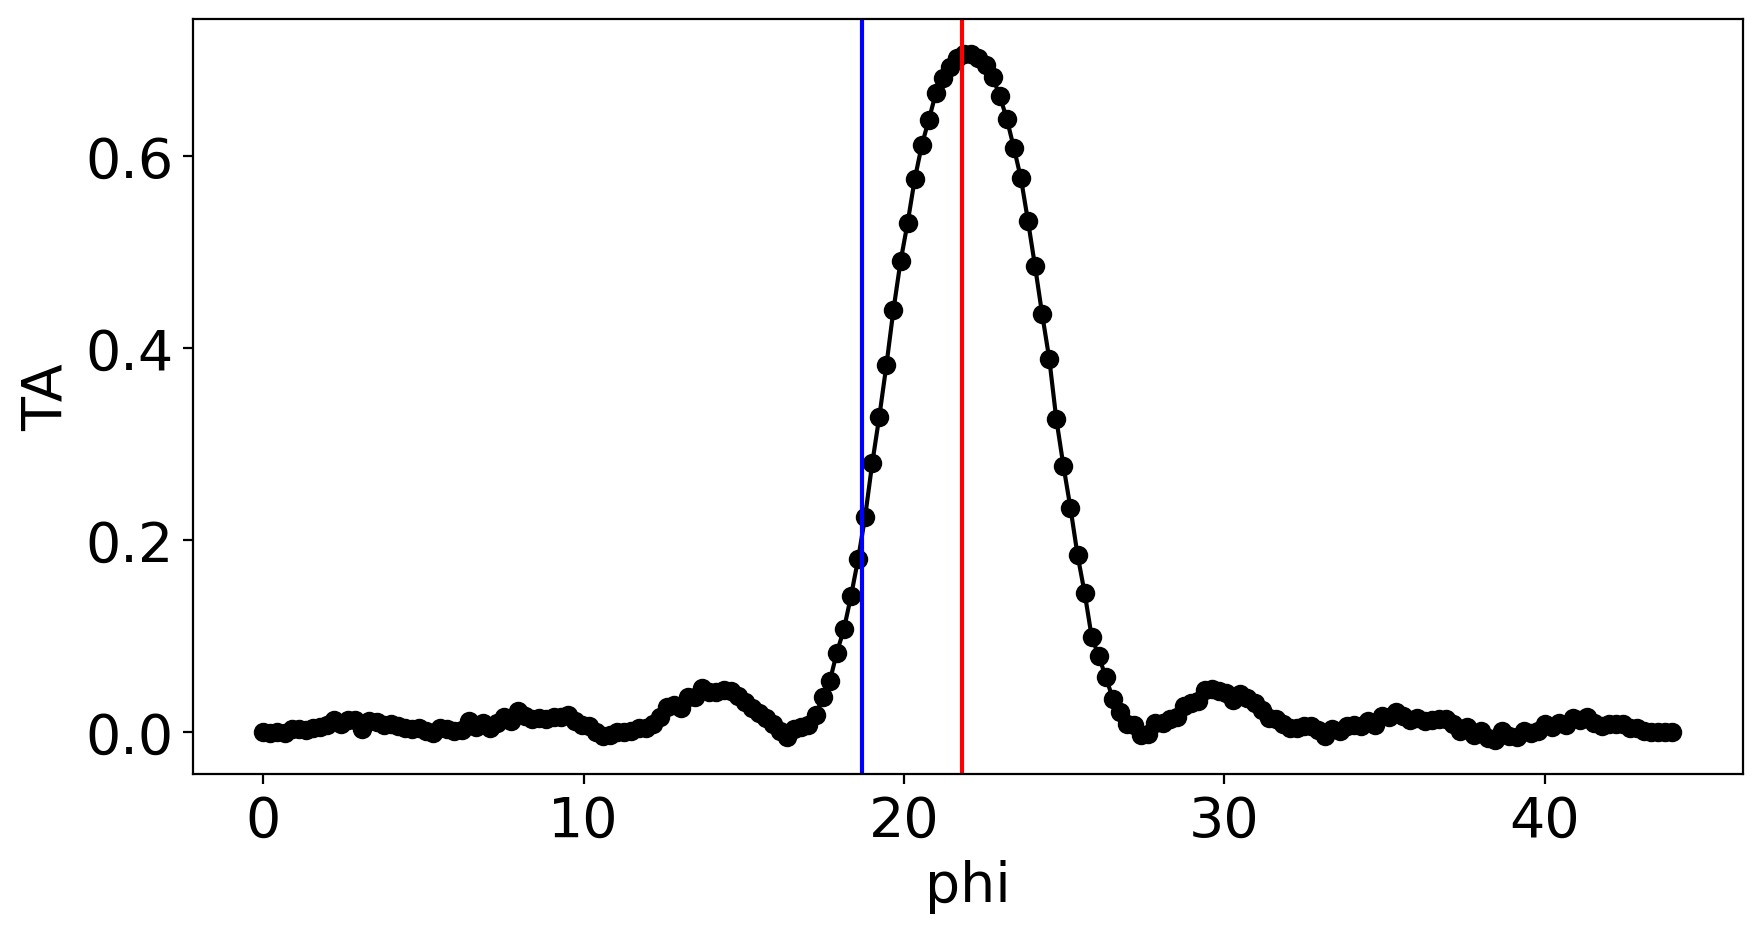

In [44]:
plt.plot(param_space, Target_a, c="k", marker="o")
plt.axvline(x = initial_param, color = 'b', label = 'axvline - full height')
plt.axvline(x = end_param, color = 'r', label = 'axvline - full height')
plt.xlabel("phi")
plt.ylabel("TA")
plt.show()

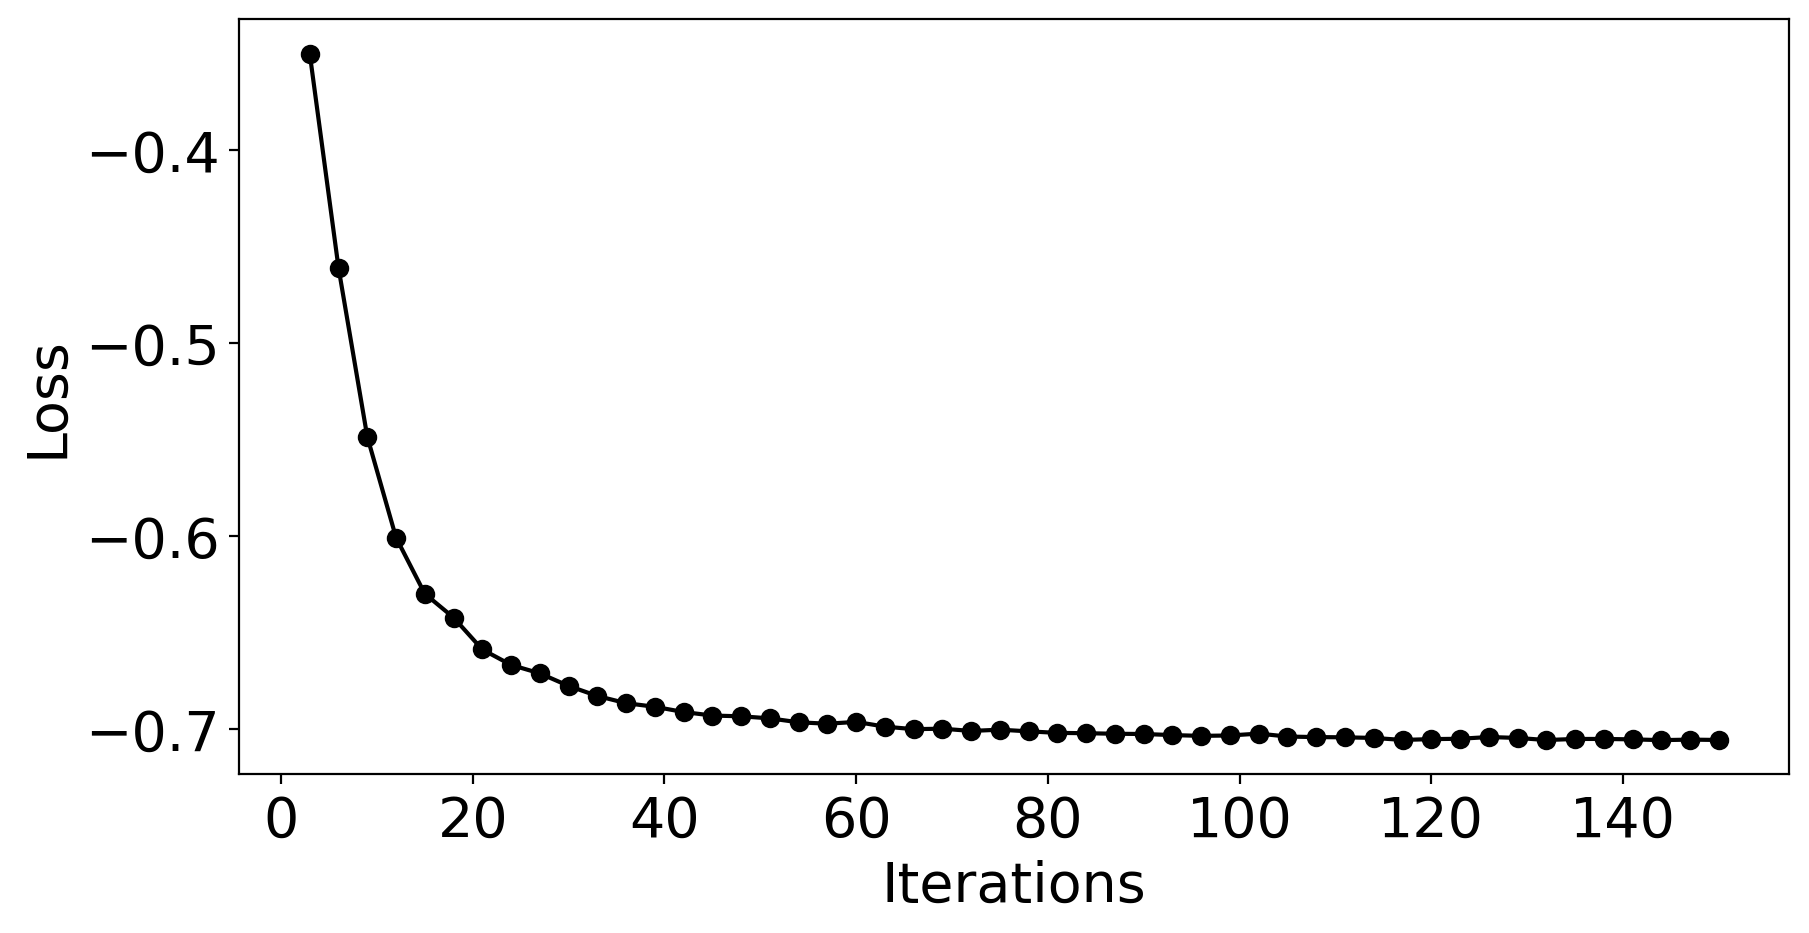

In [45]:
plt.plot(callback[0], TA, c="k", marker="o")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

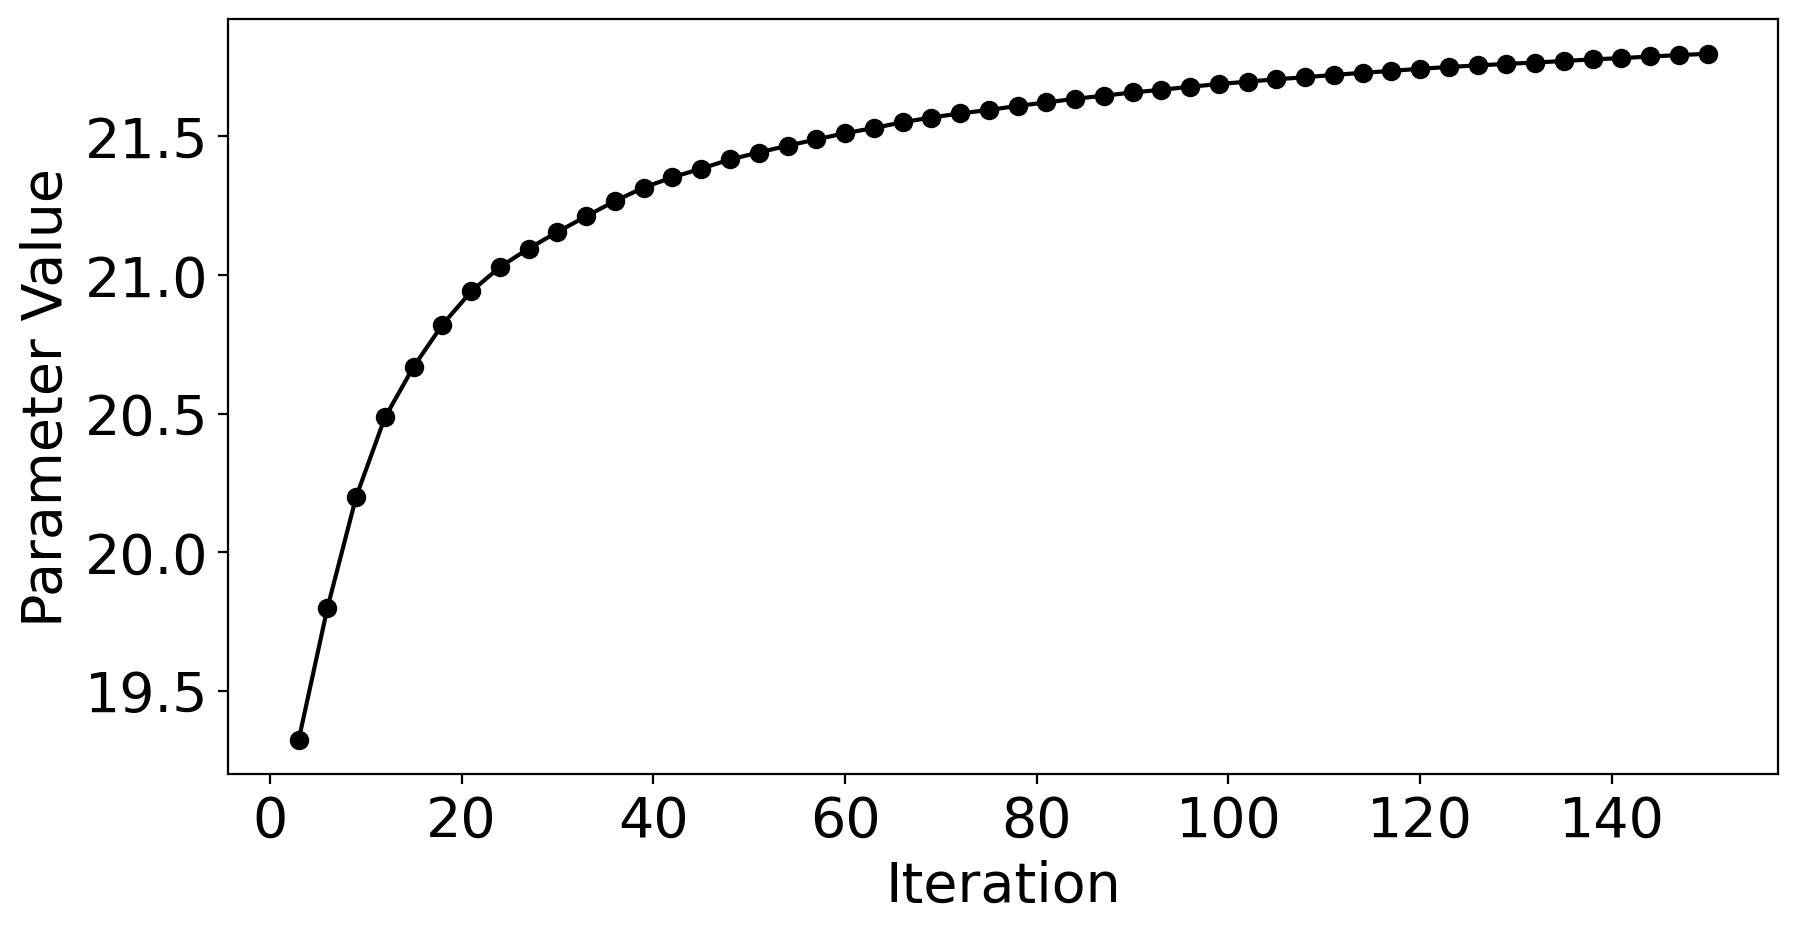

In [57]:
plt.plot(callback[0], param, c="k", marker="o")
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.show()

## Many optimization runs

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


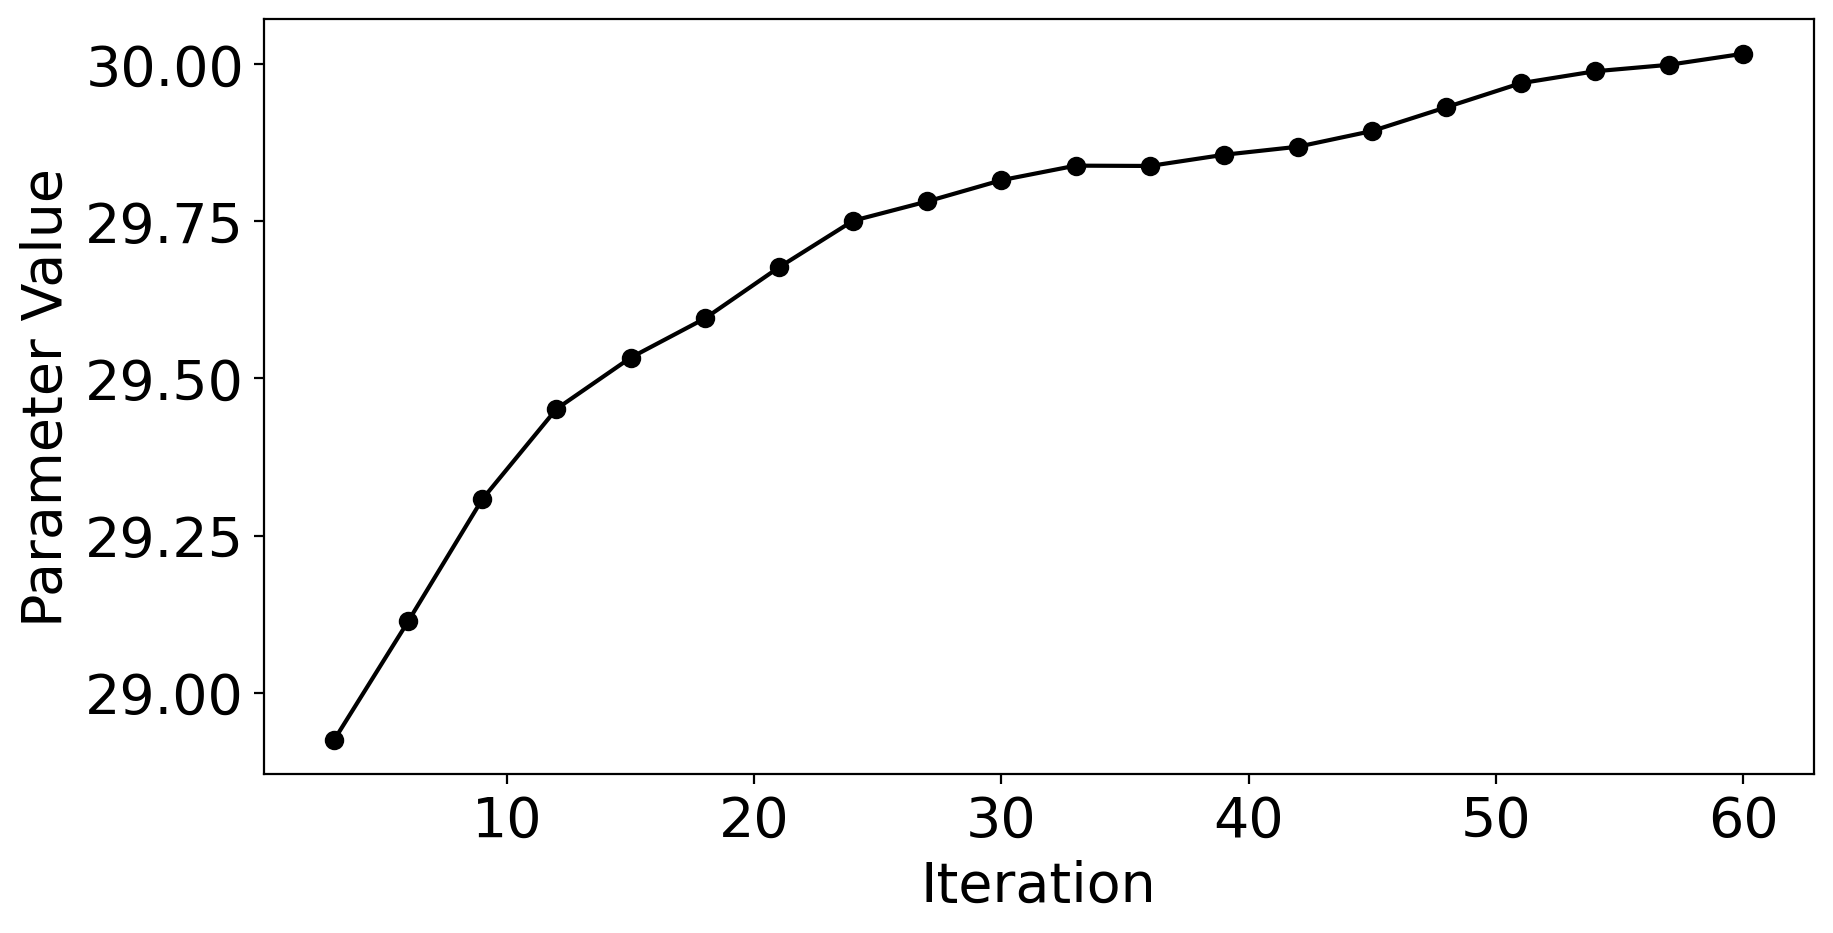

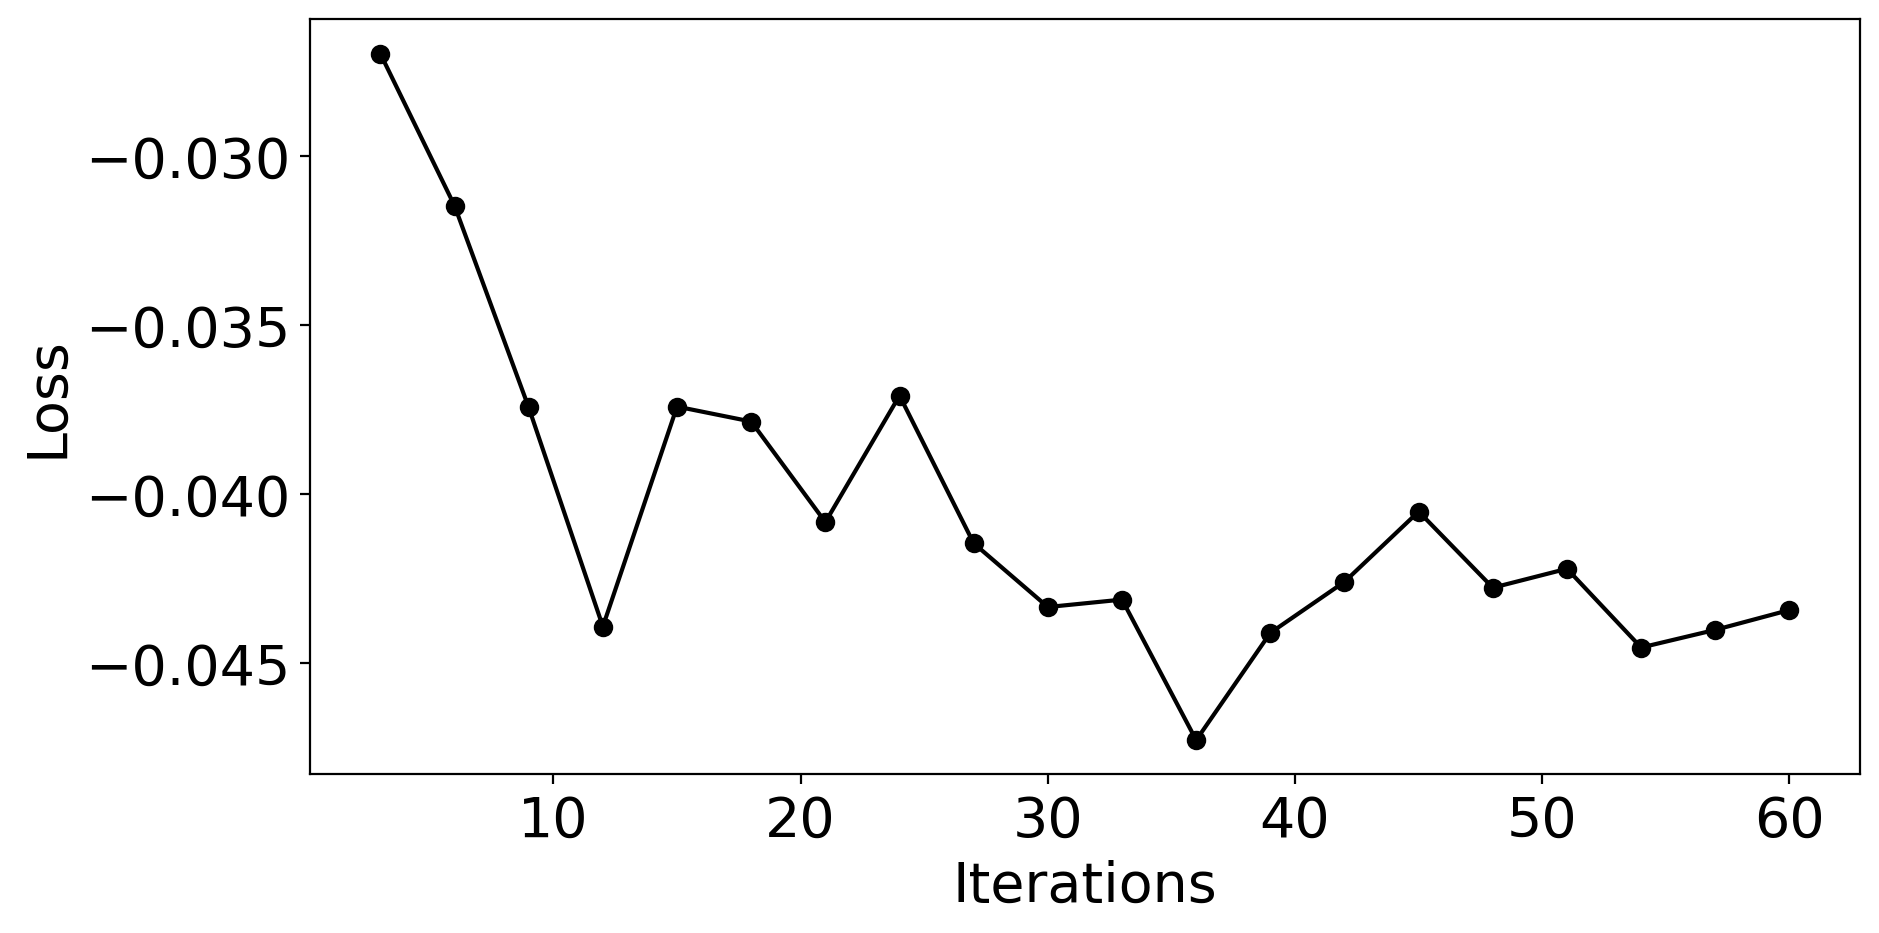

initial_point:  [28.747185447296864]
end loss:  -0.04343086827965874
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


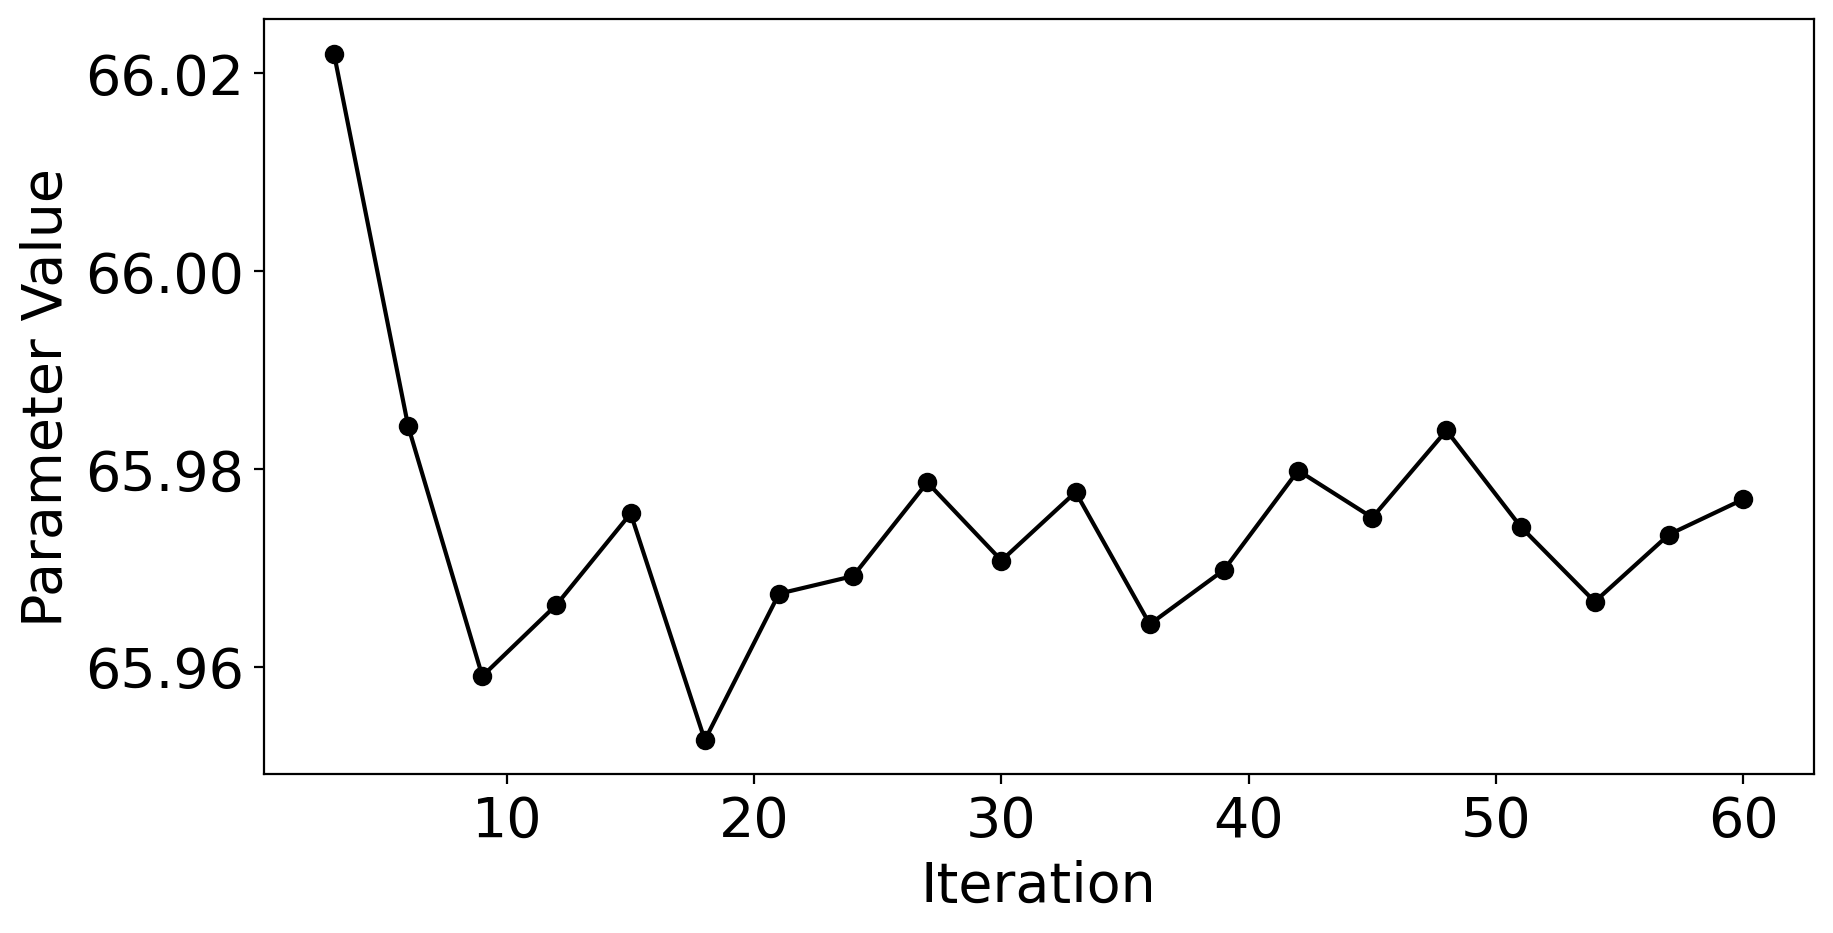

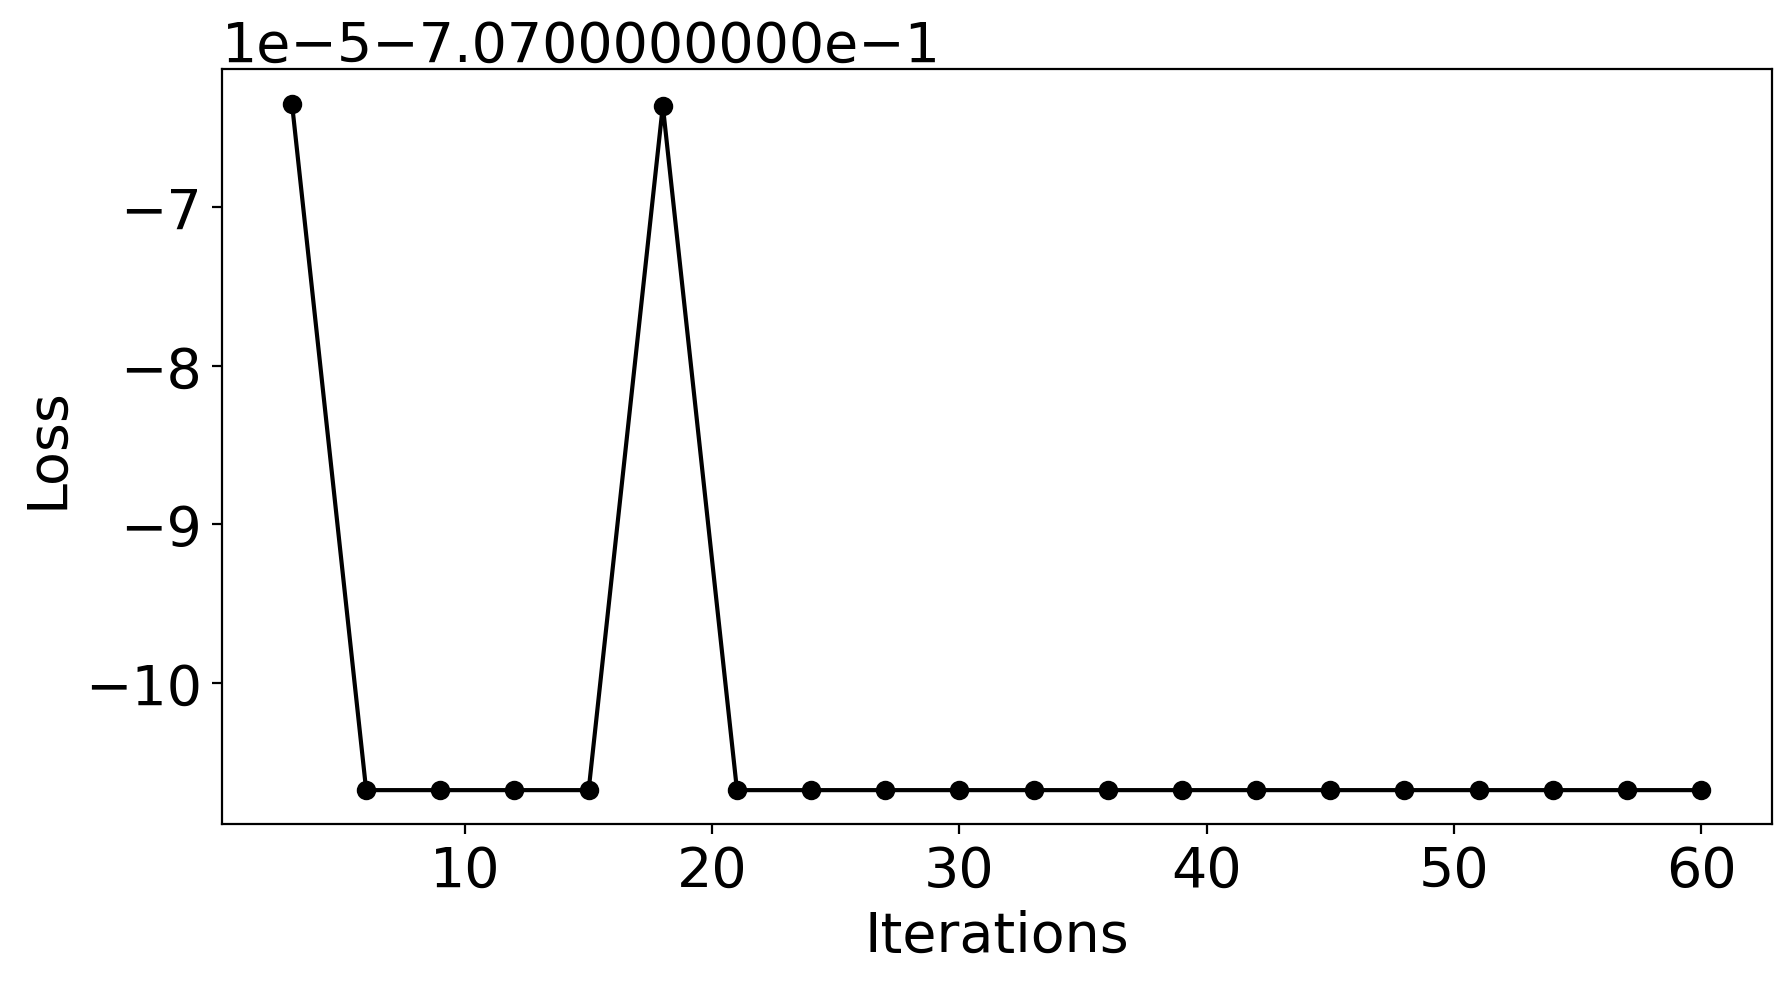

initial_point:  [67.98457437036222]
end loss:  -0.7071067811865475
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


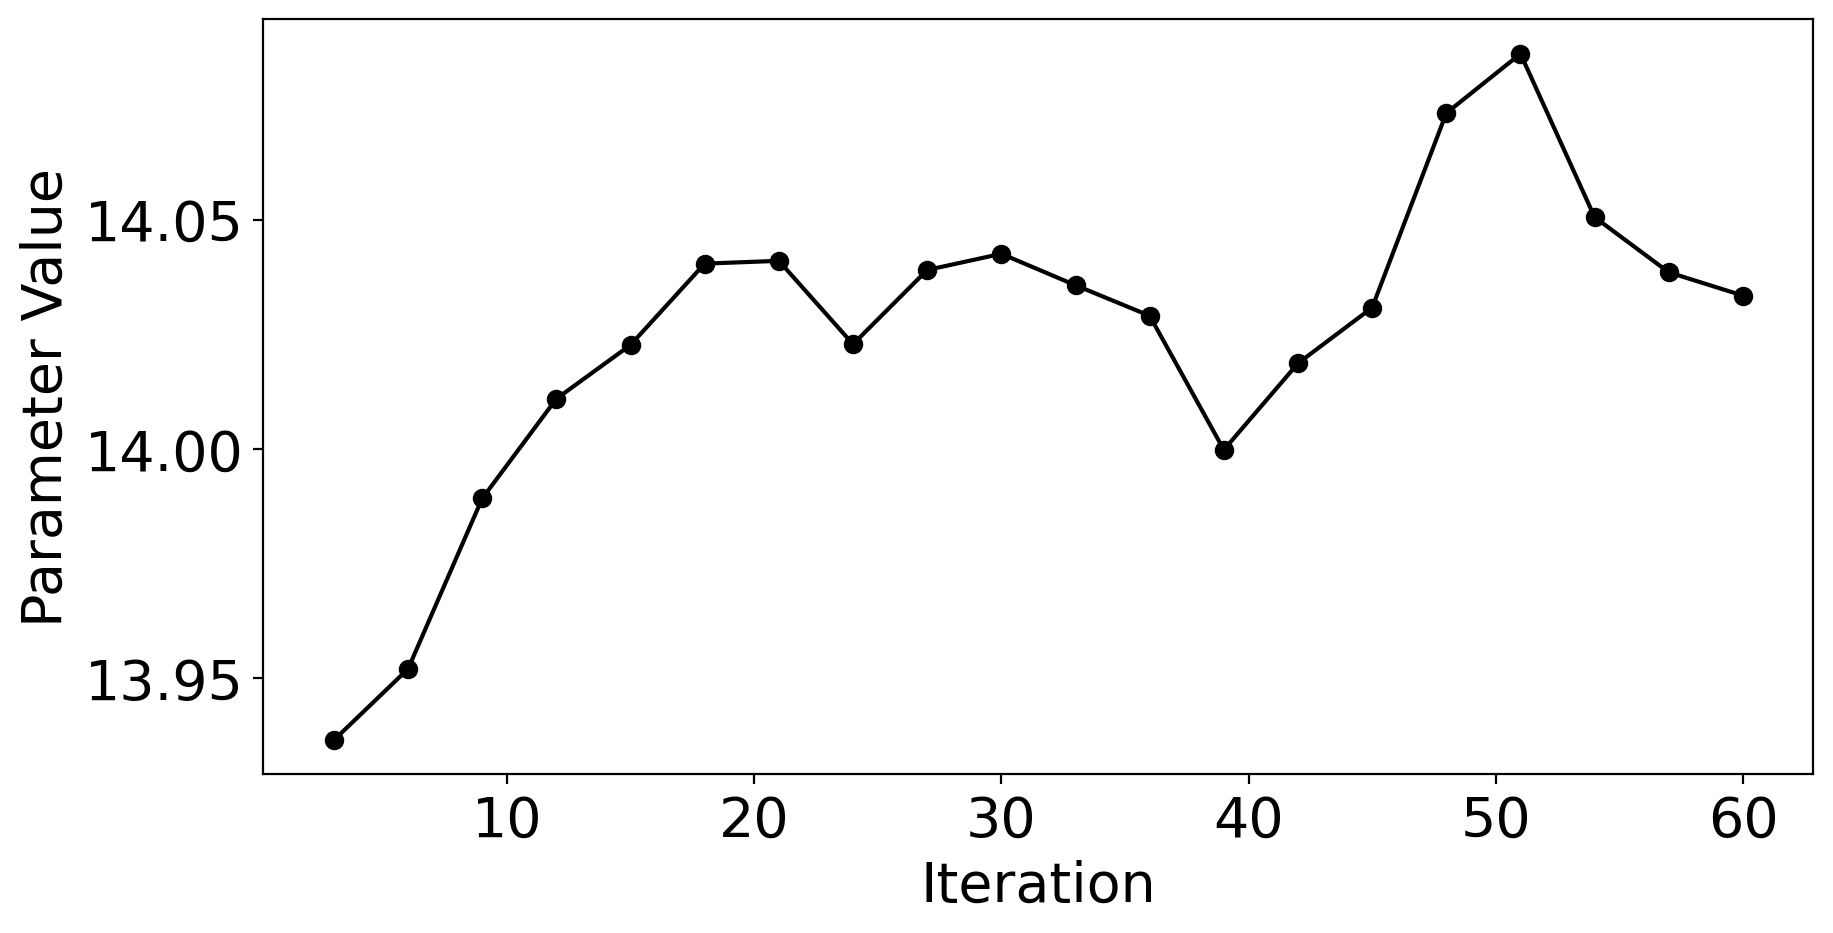

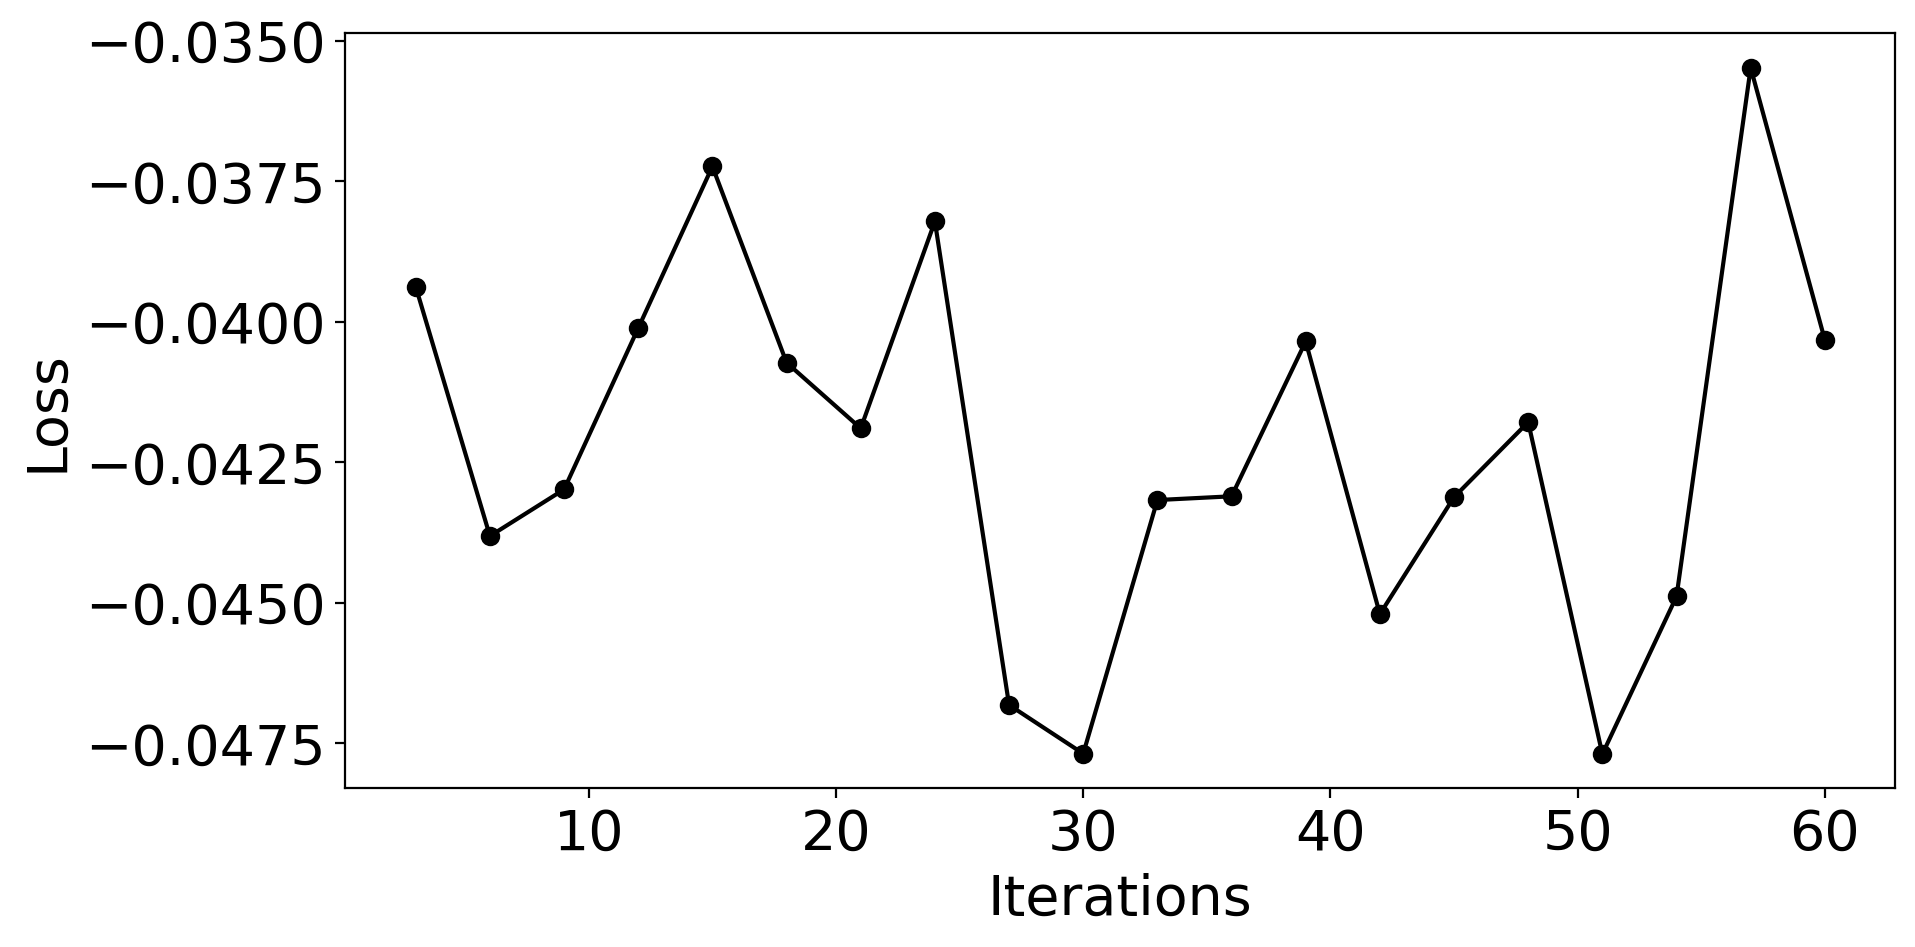

initial_point:  [13.897978168559677]
end loss:  -0.04032153545538722
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


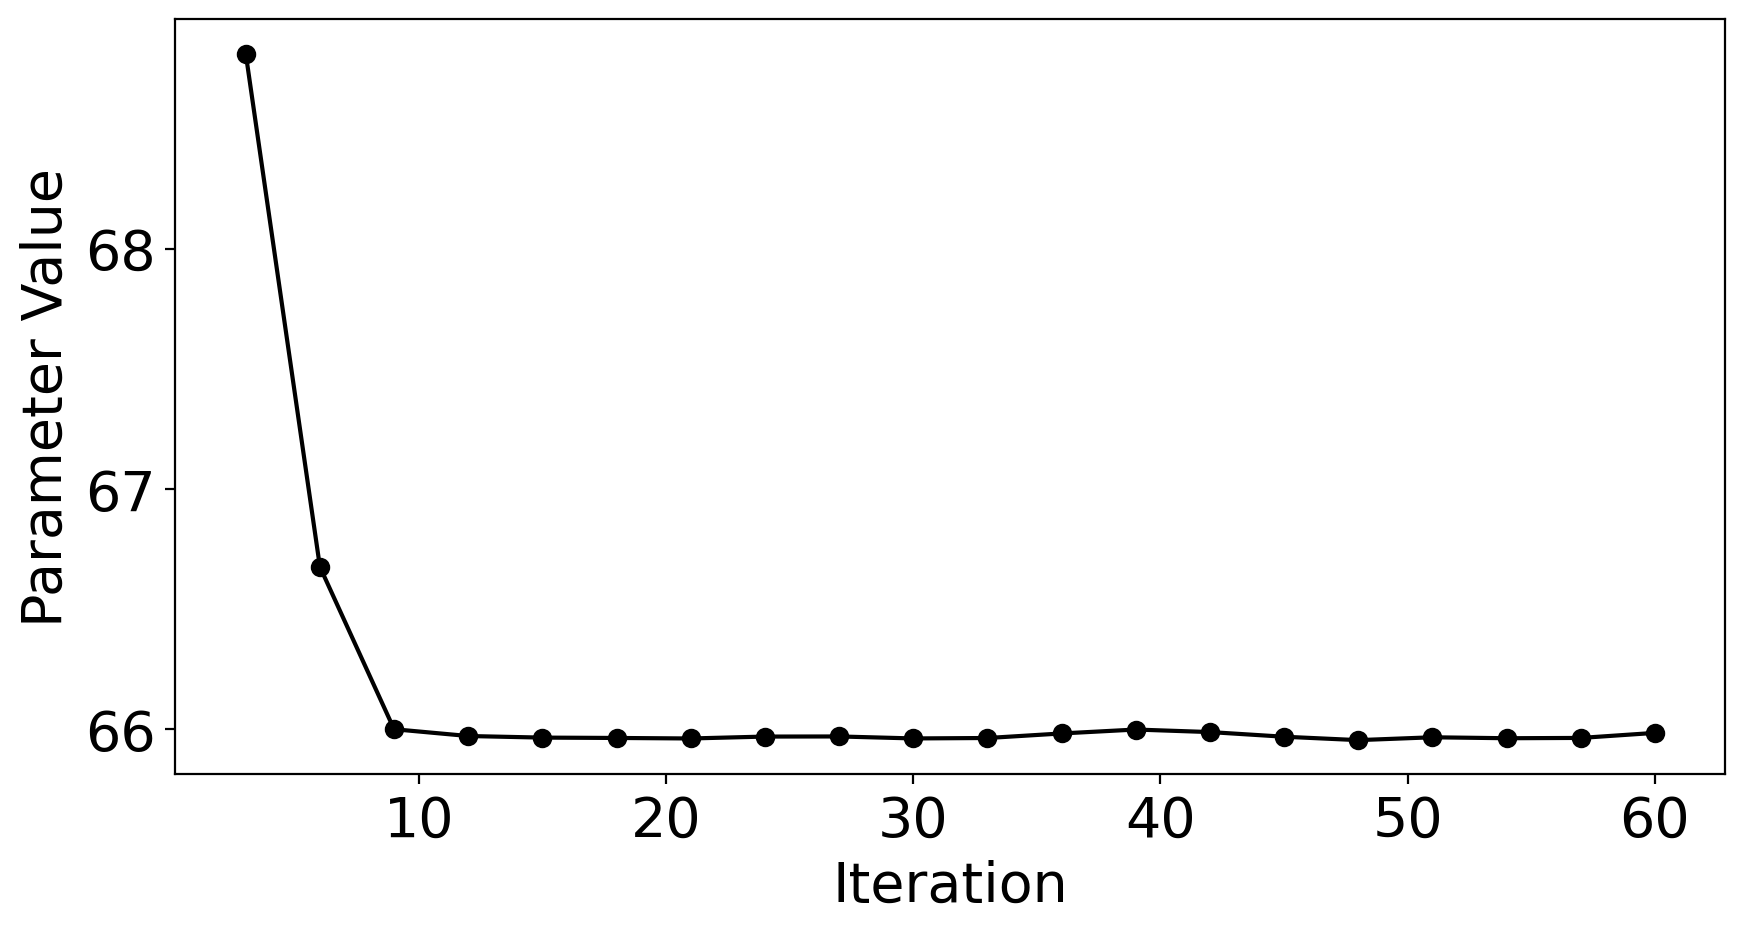

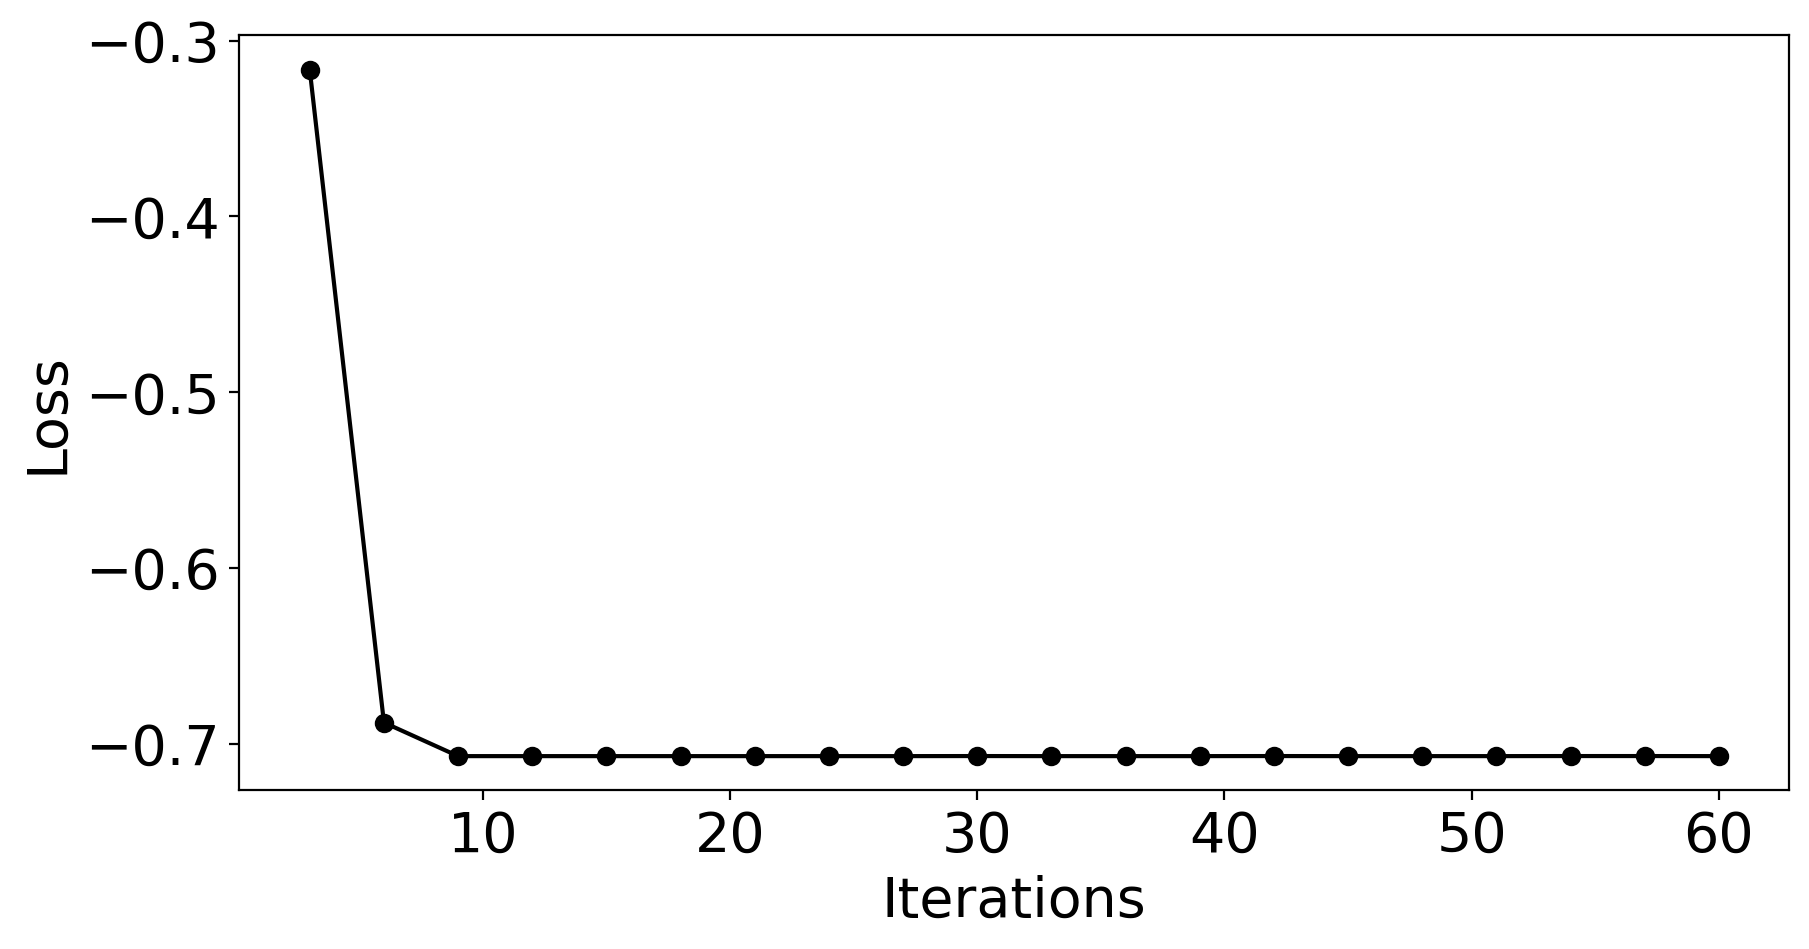

initial_point:  [70.0420952515204]
end loss:  -0.7071067811865475
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


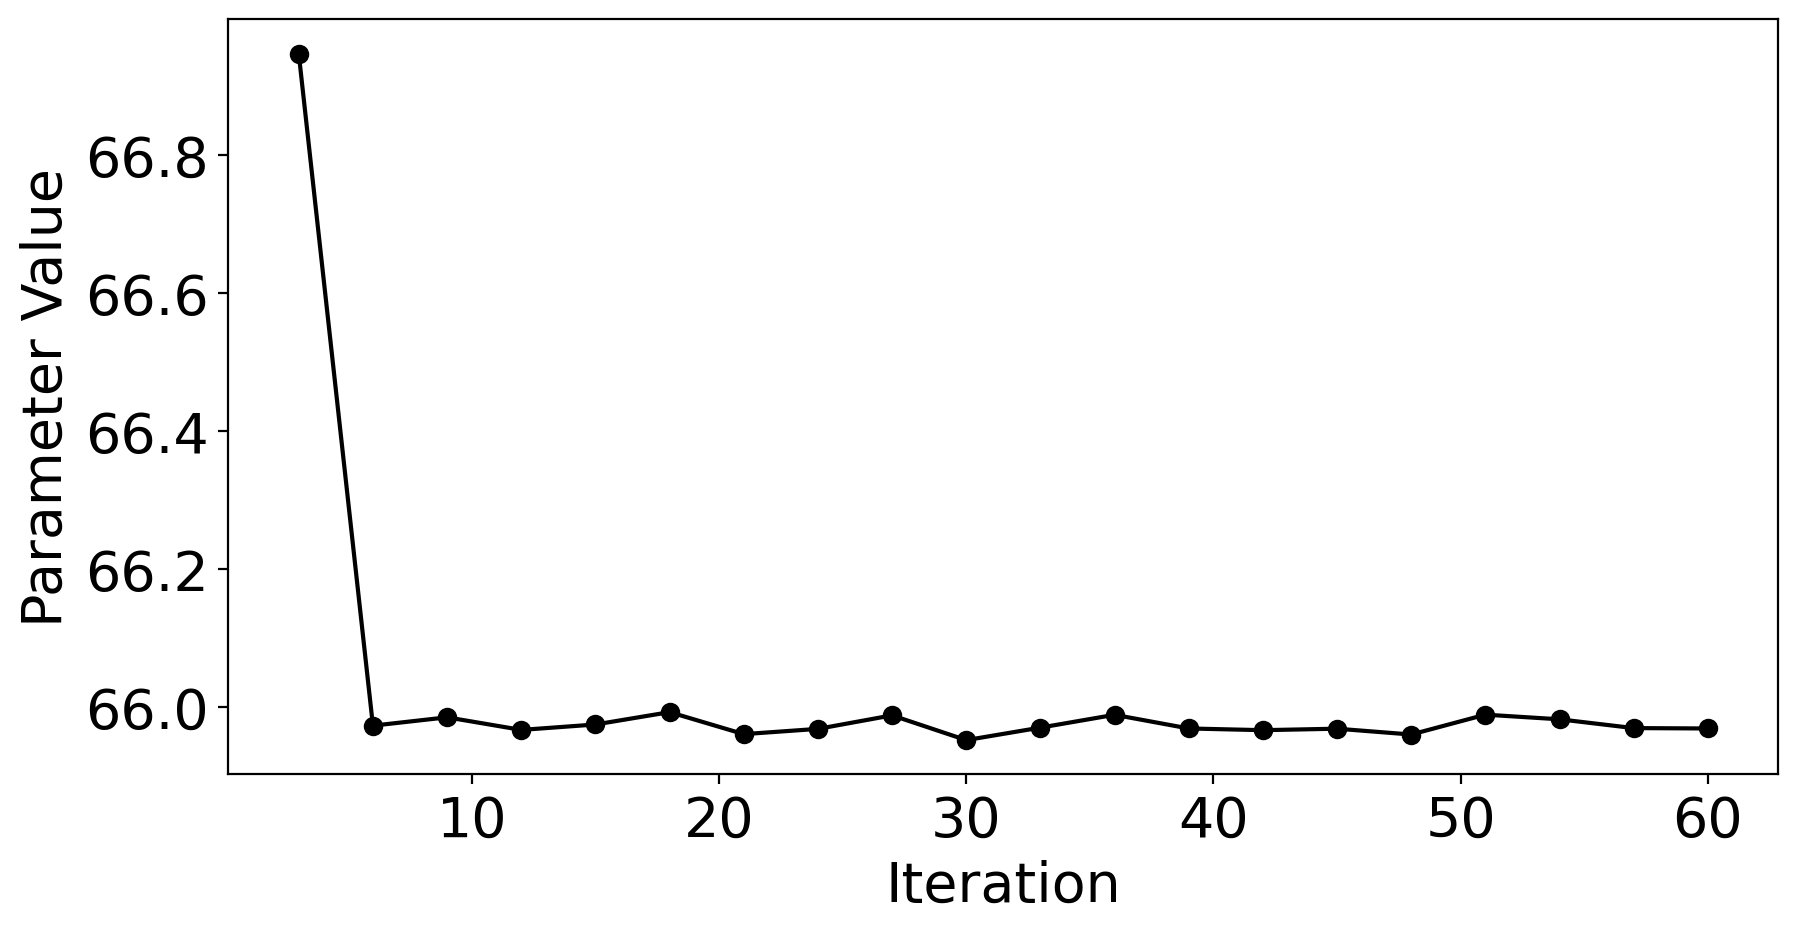

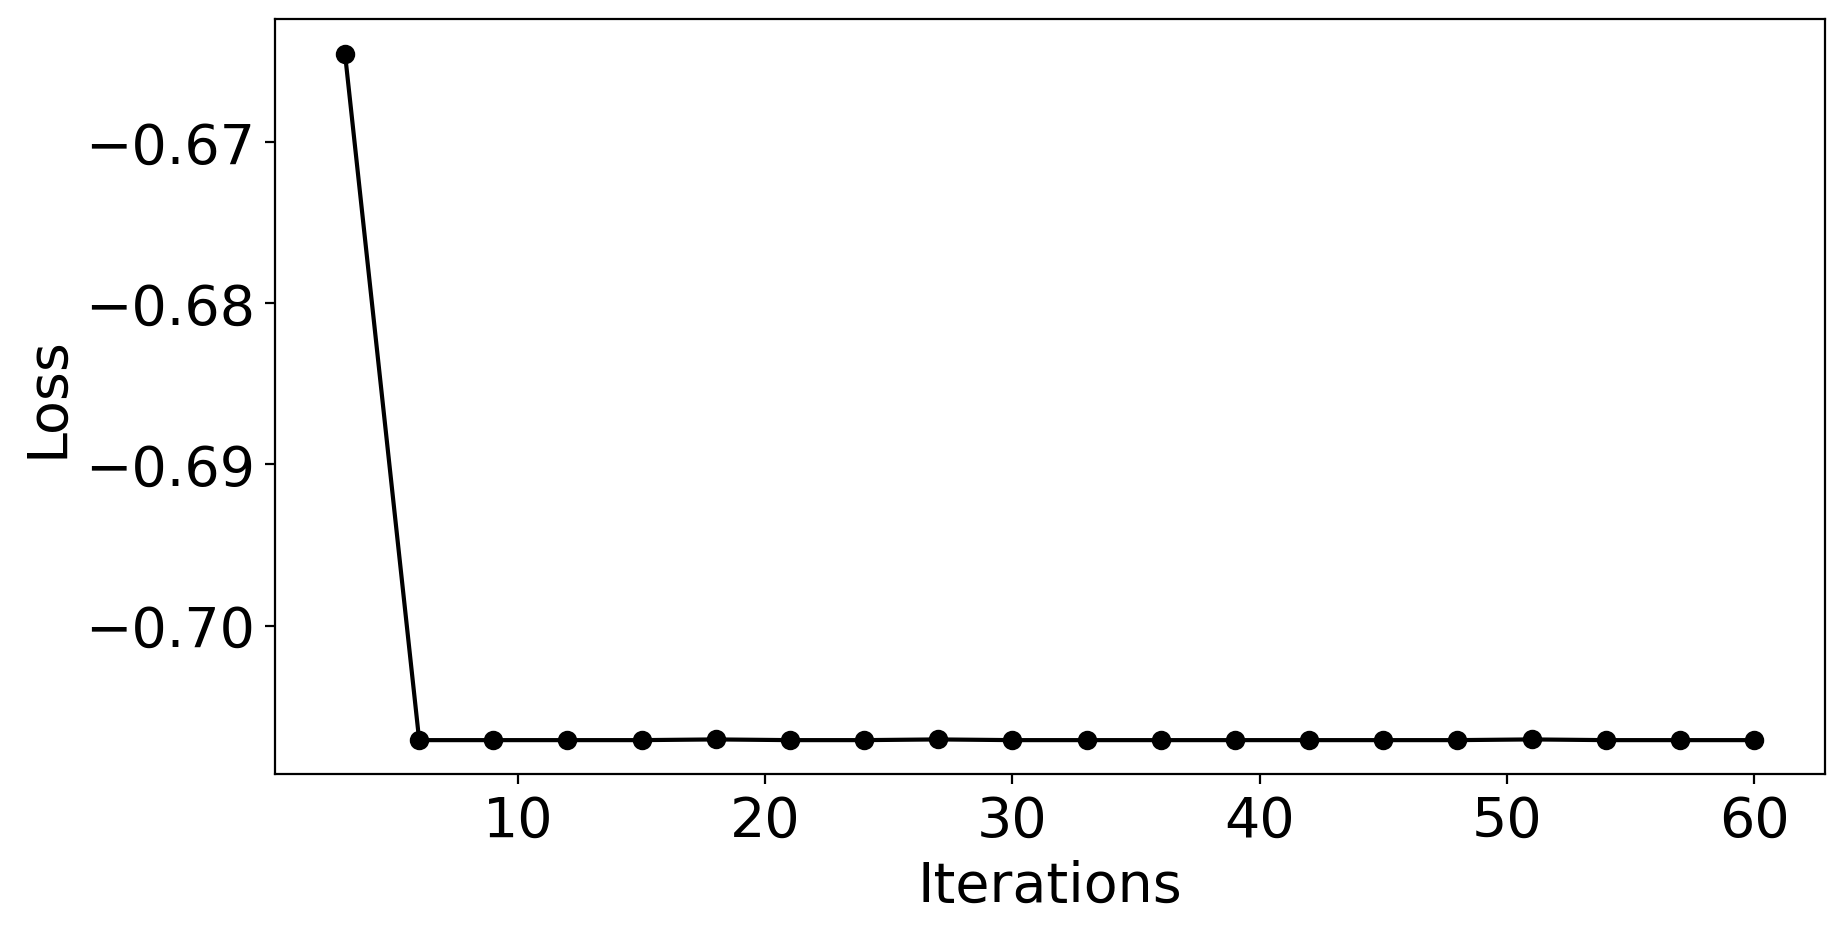

initial_point:  [69.00776941138528]
end loss:  -0.7071067811865475
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


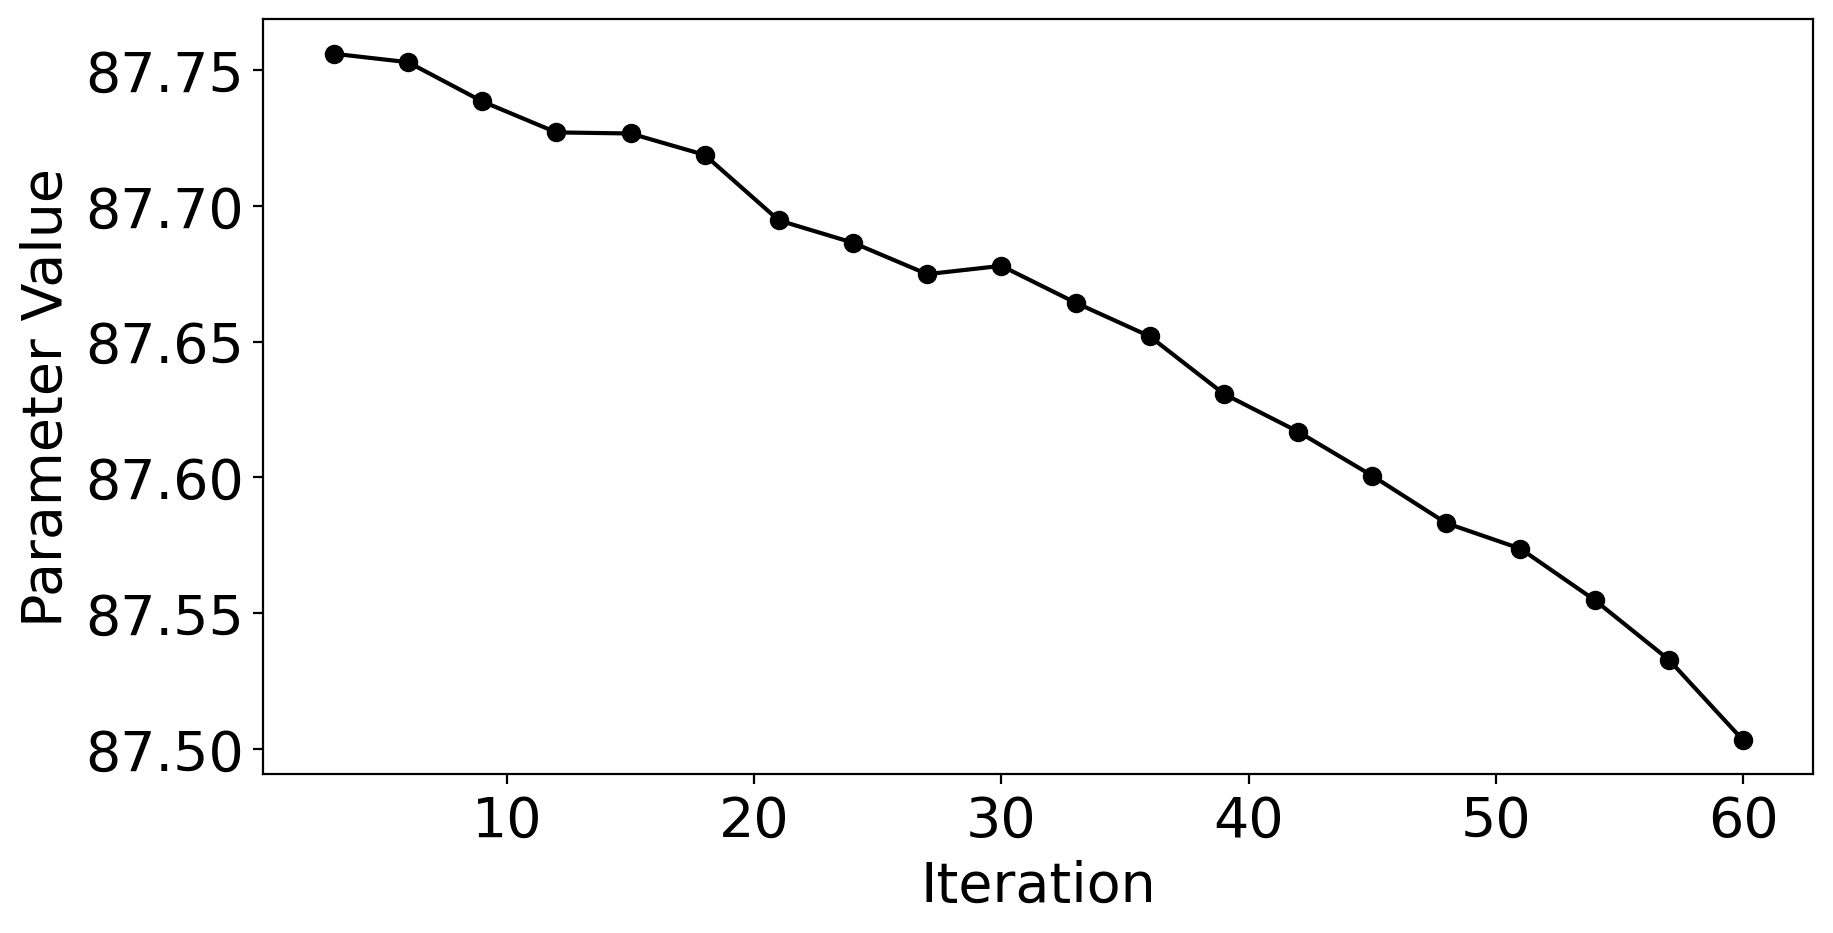

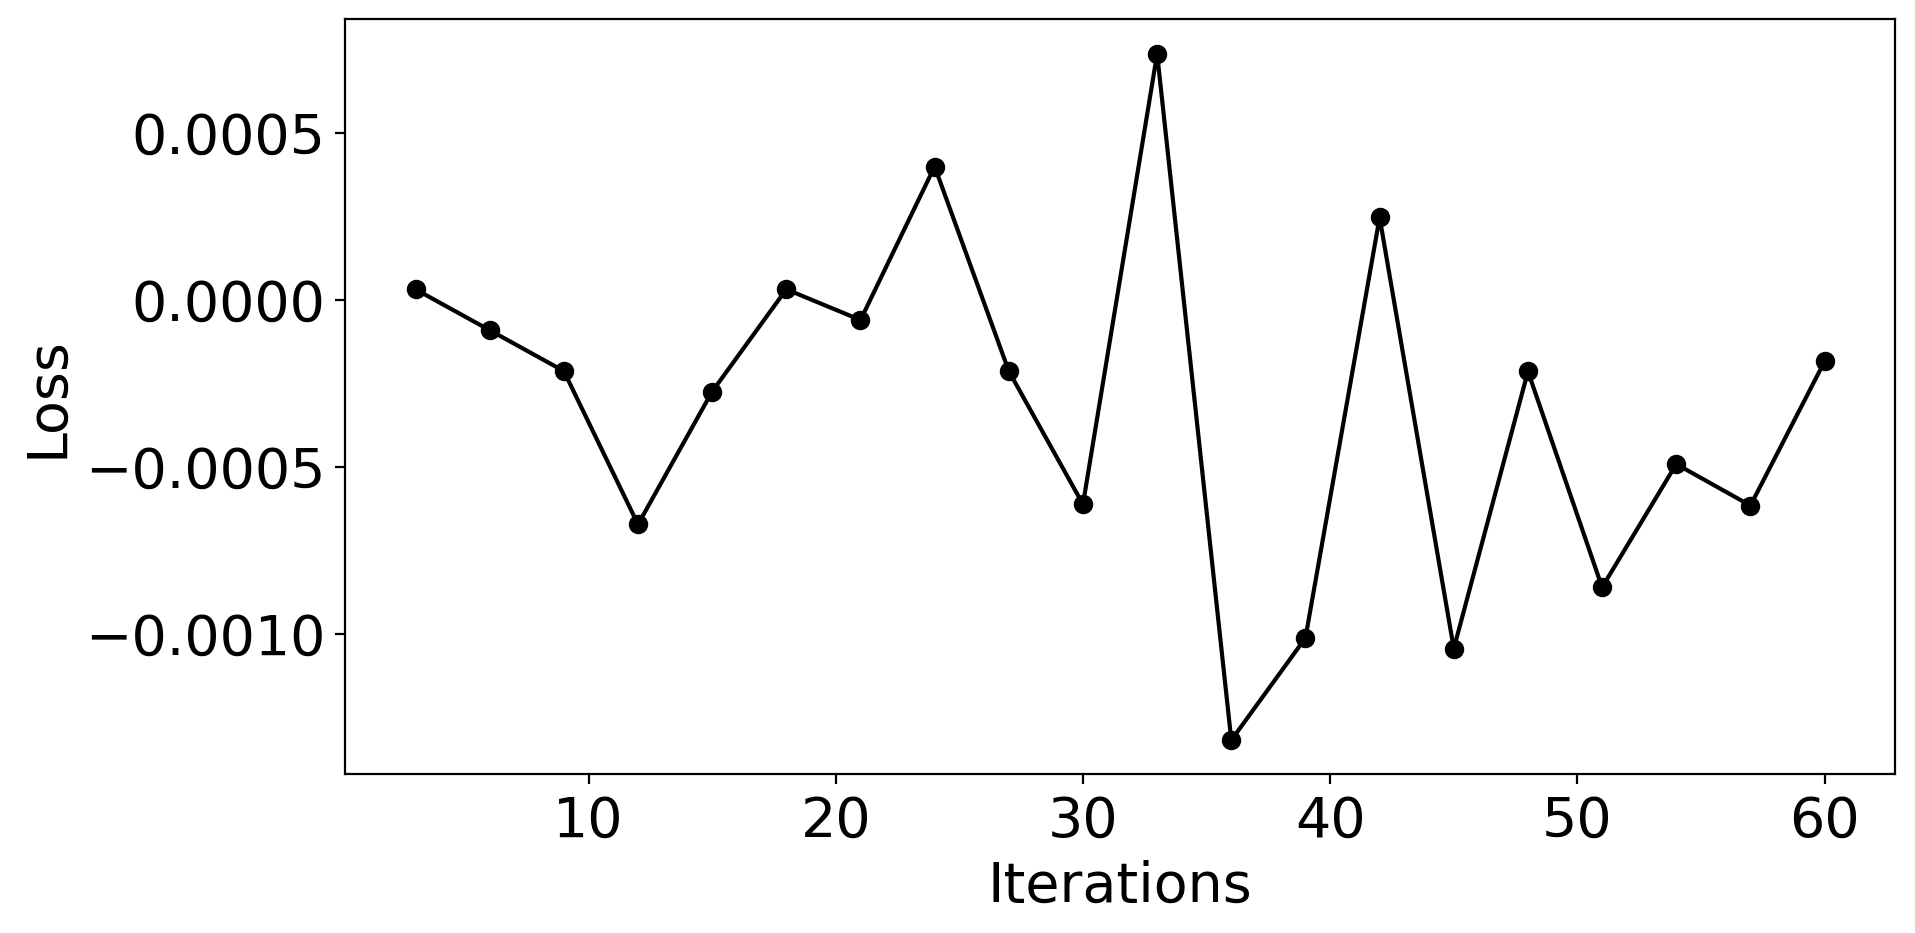

initial_point:  [87.76503457769496]
end loss:  -0.0001851112795678354
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


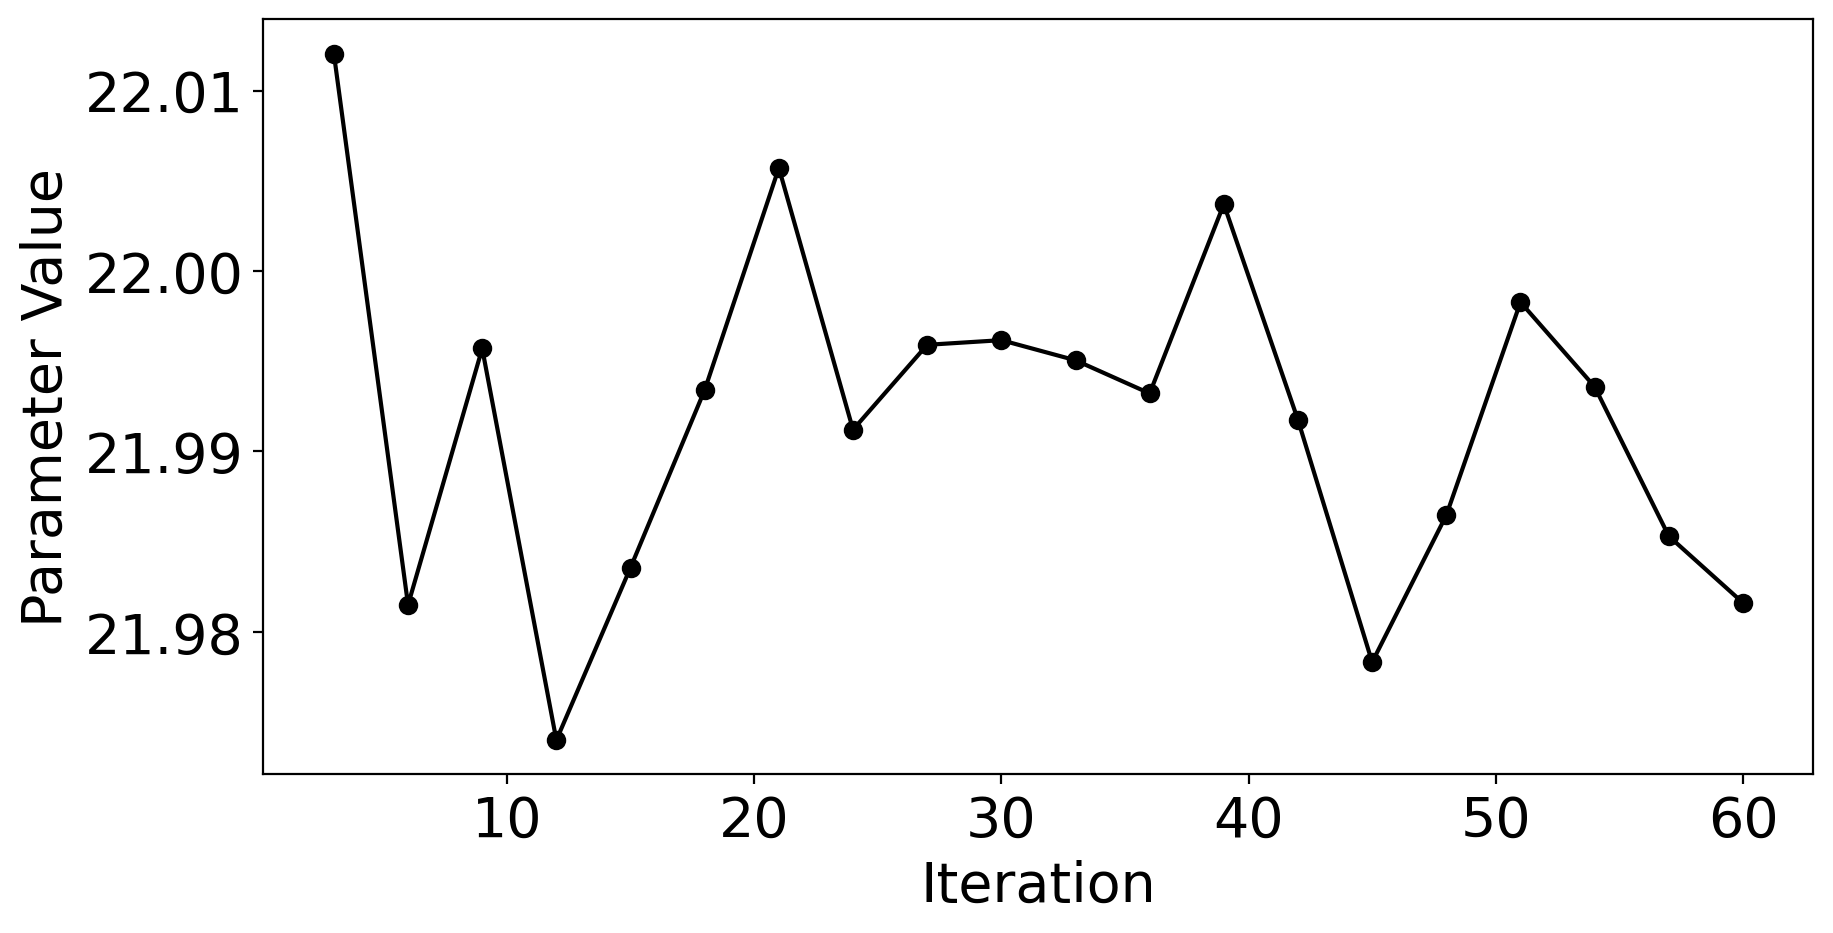

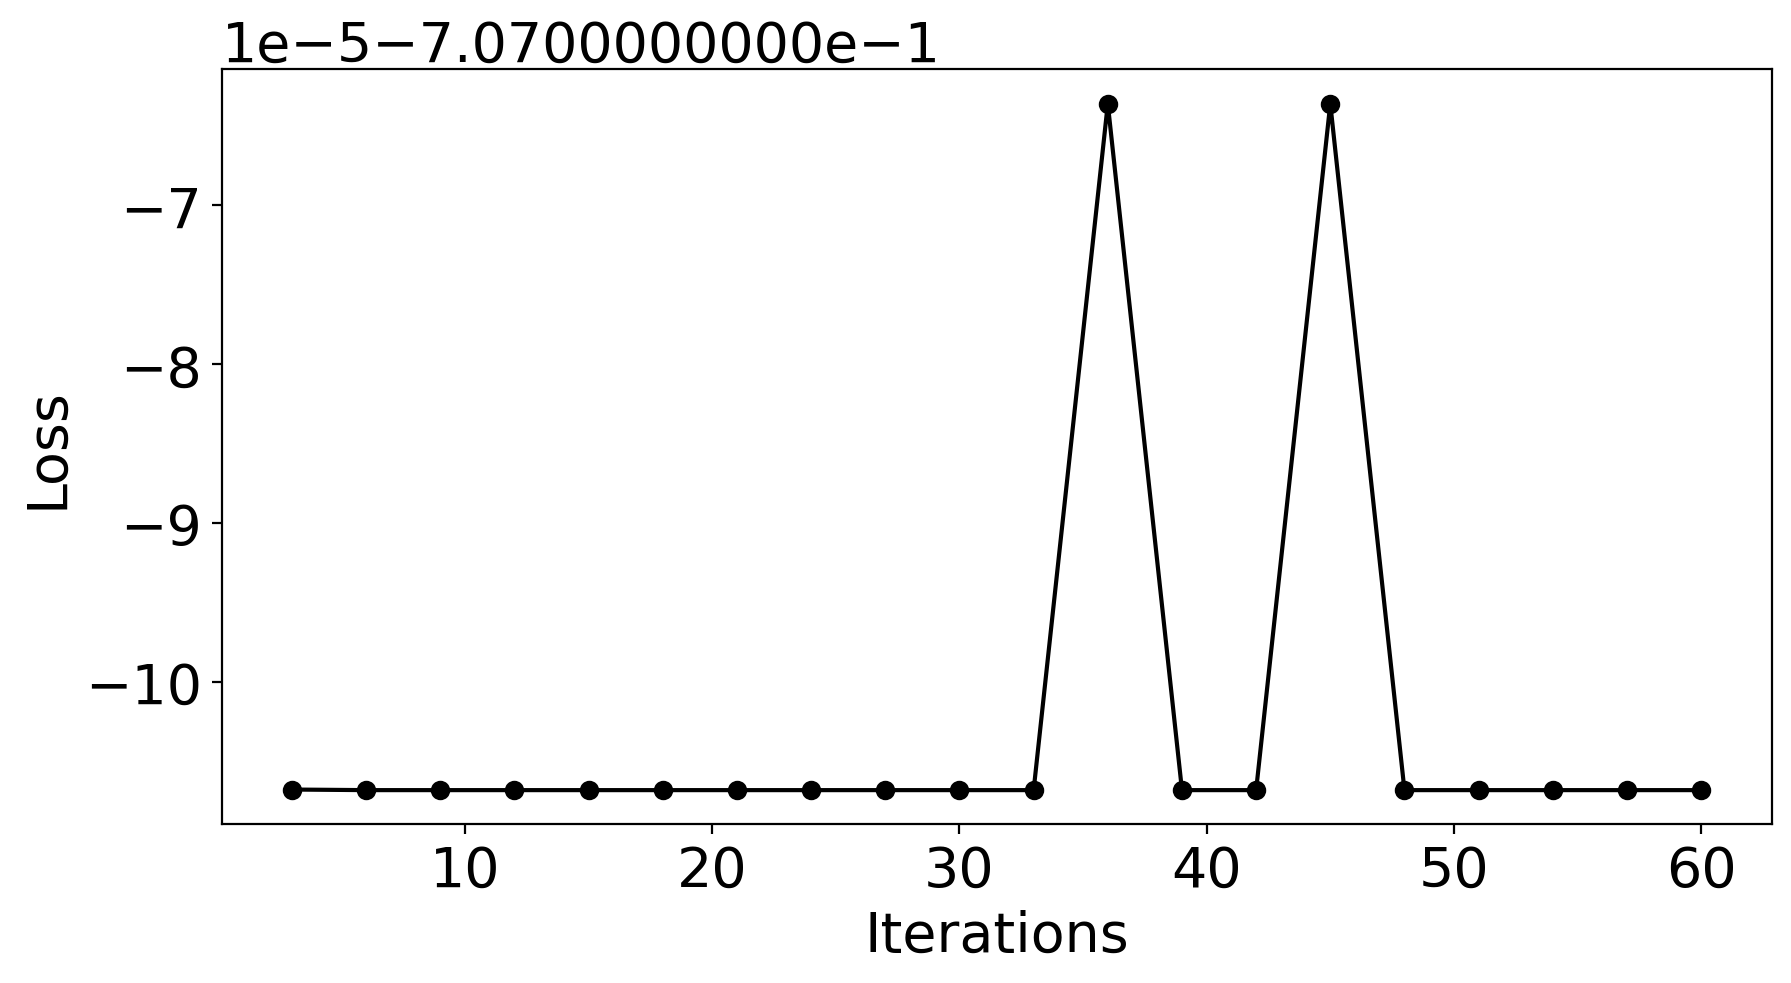

initial_point:  [23.830812199630103]
end loss:  -0.7071067811865475
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


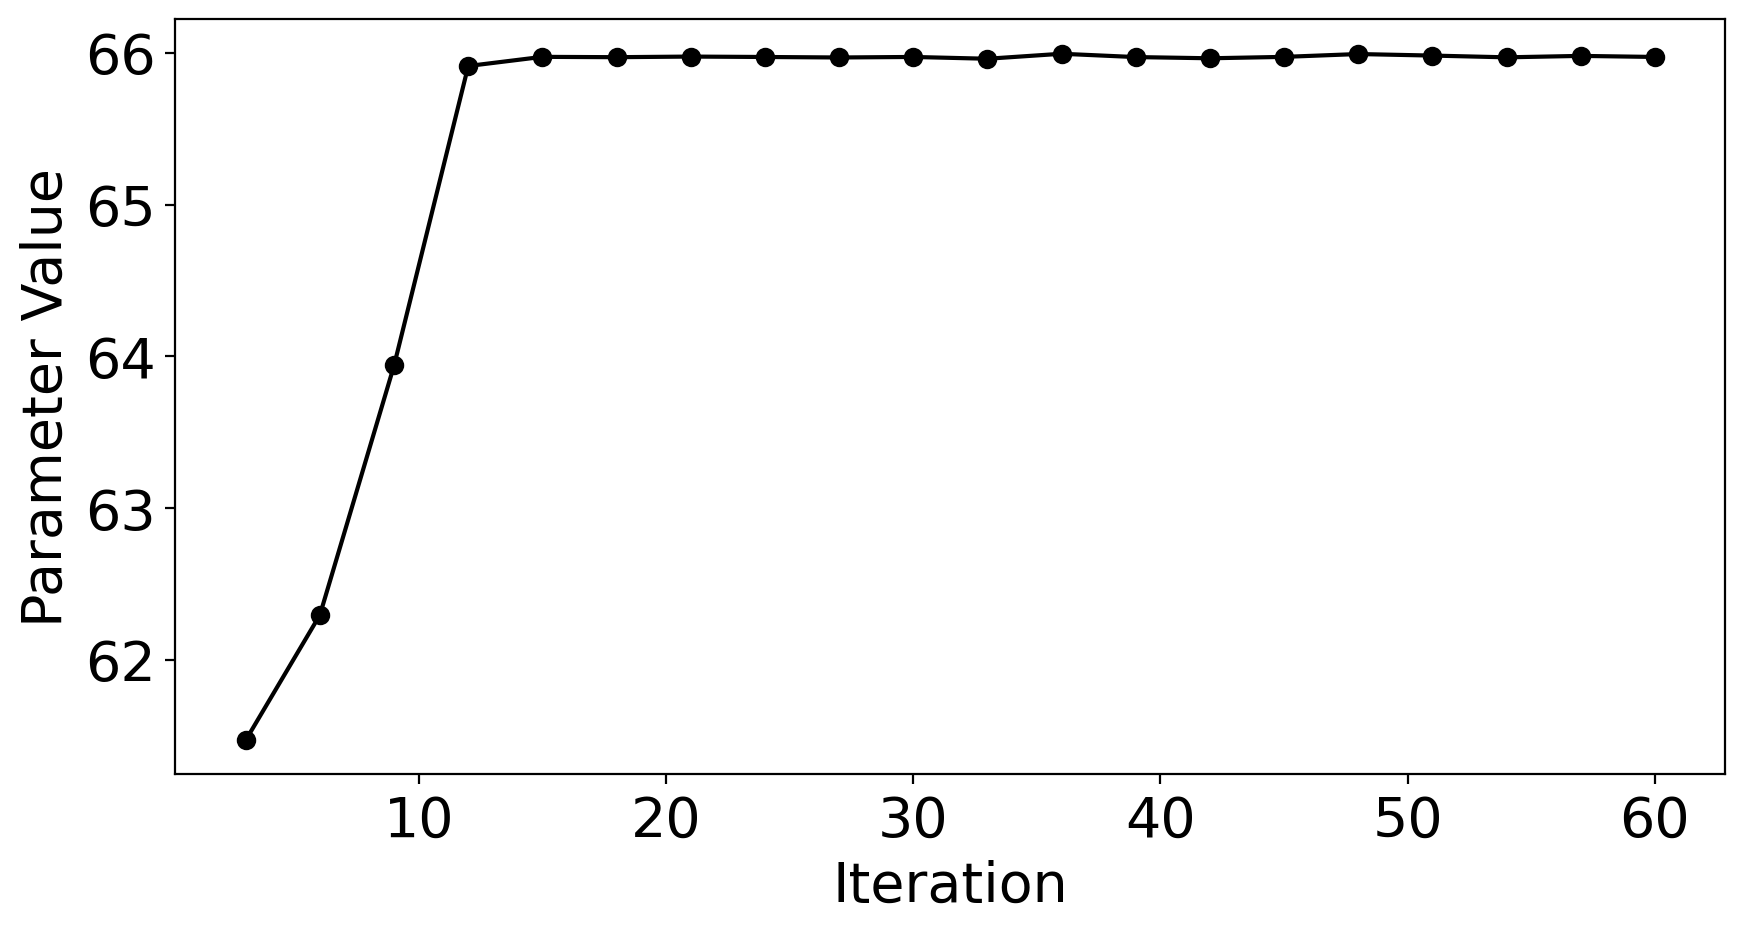

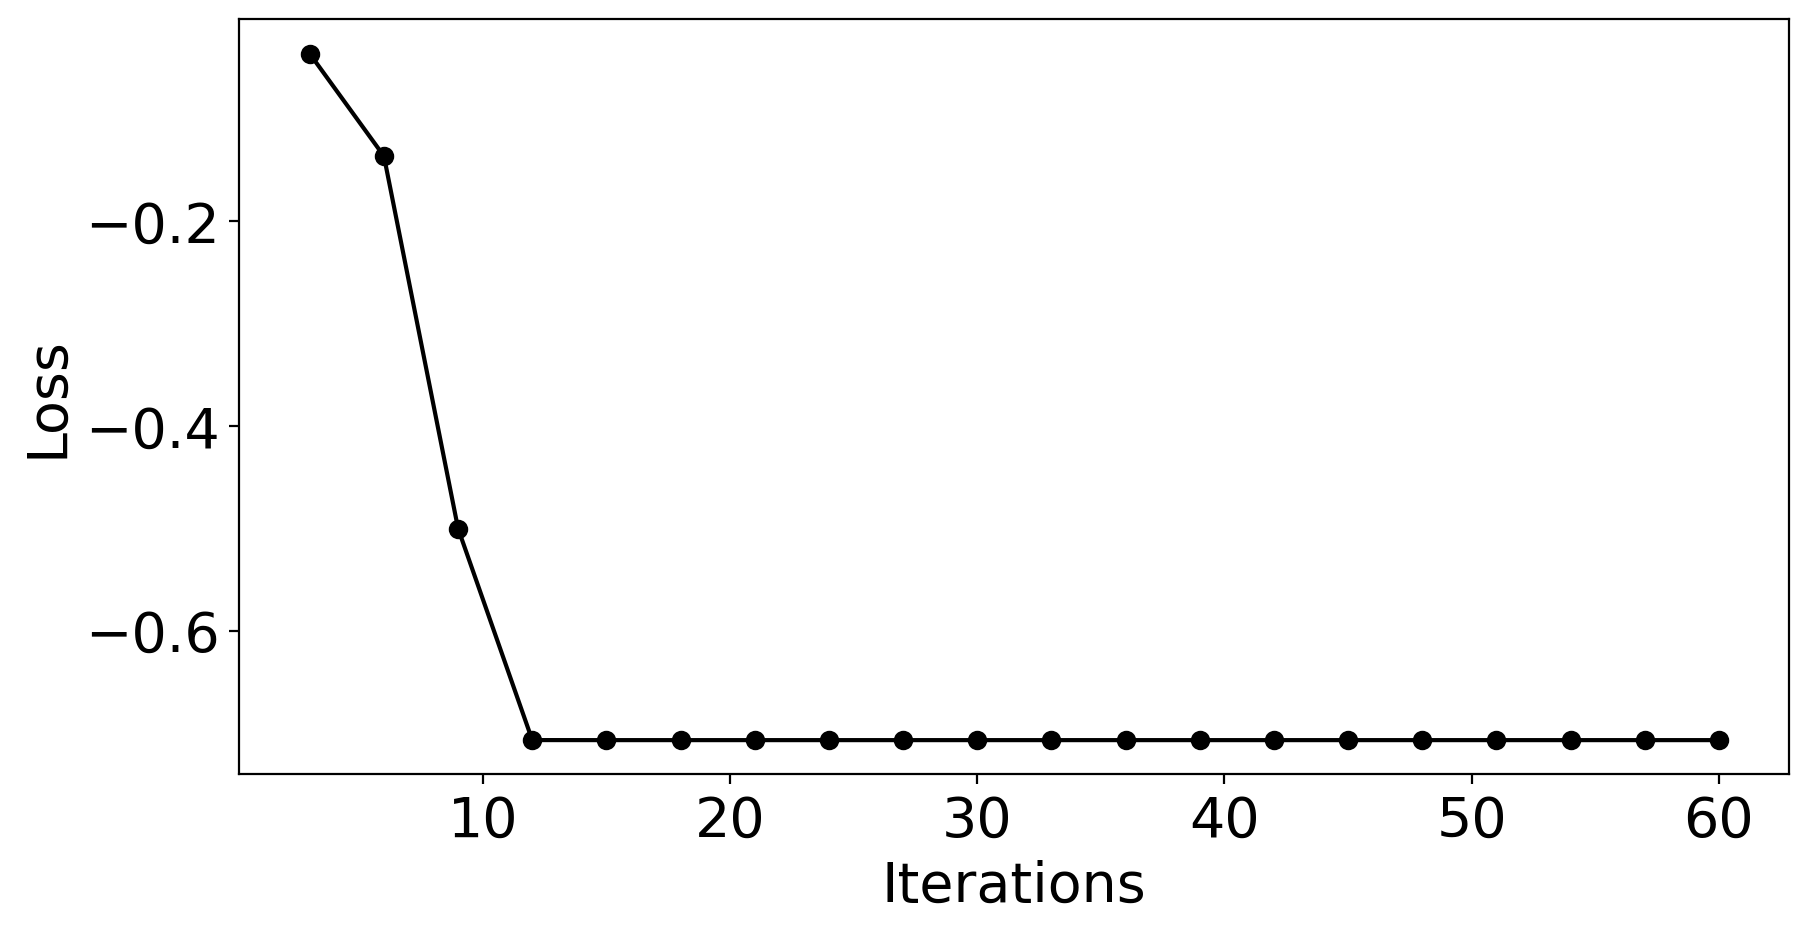

initial_point:  [61.00098680153355]
end loss:  -0.7071067811865475
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


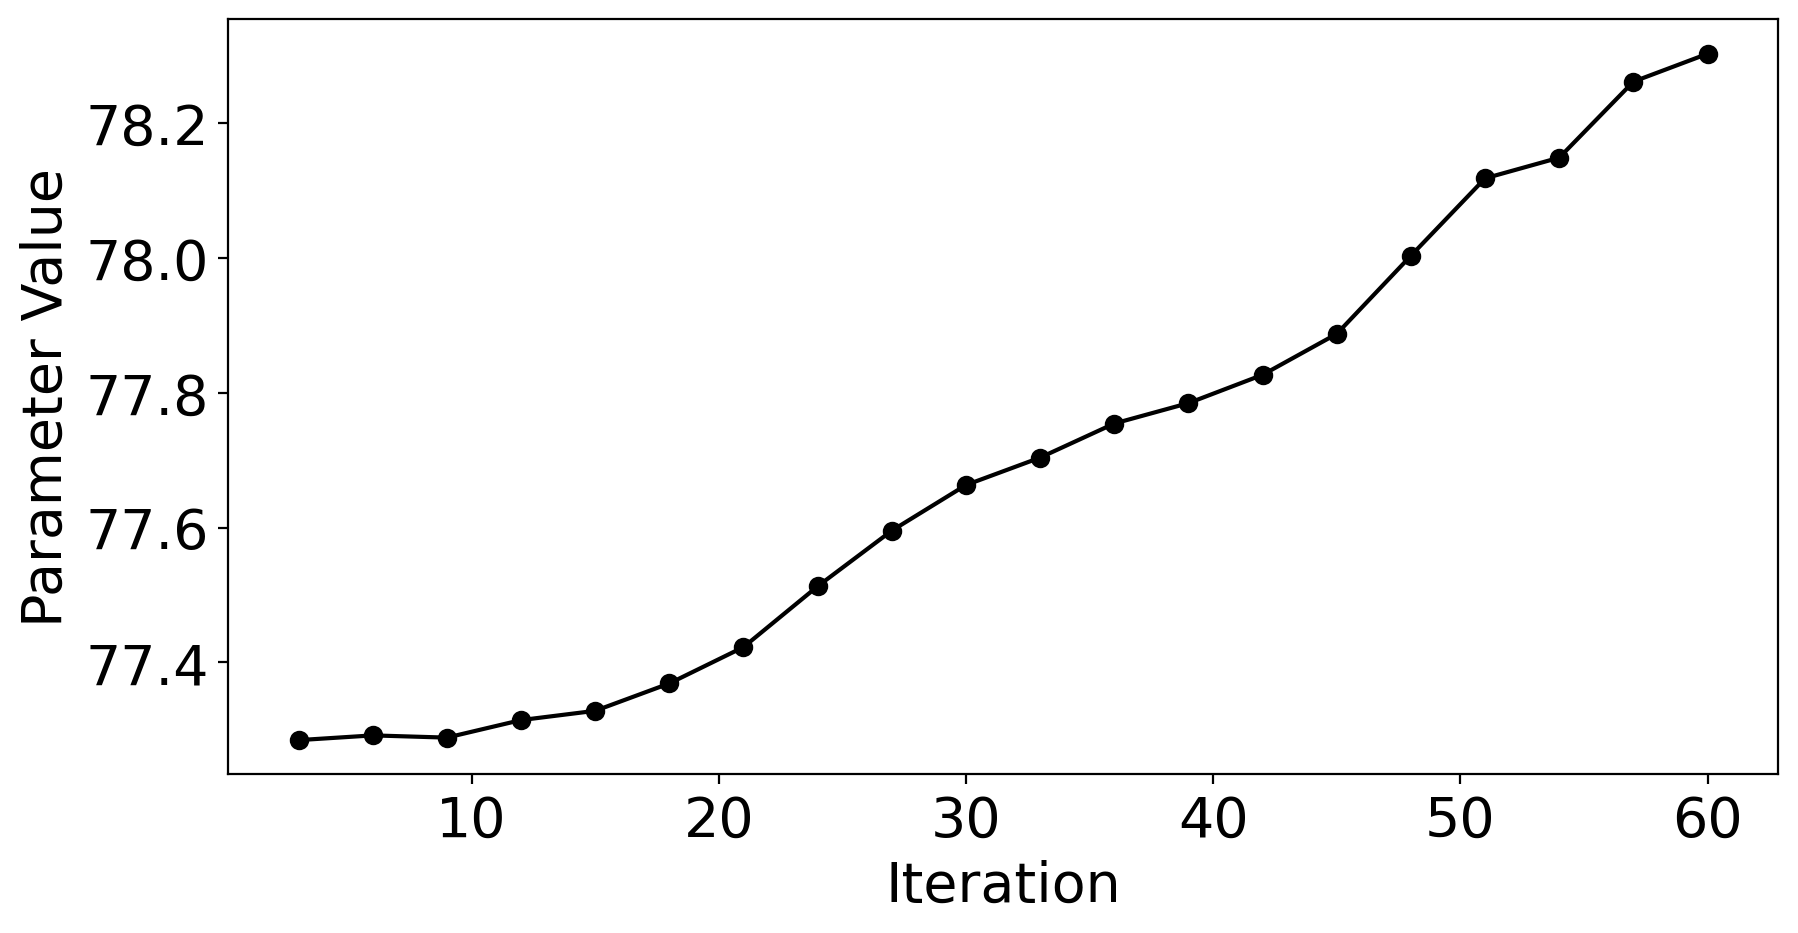

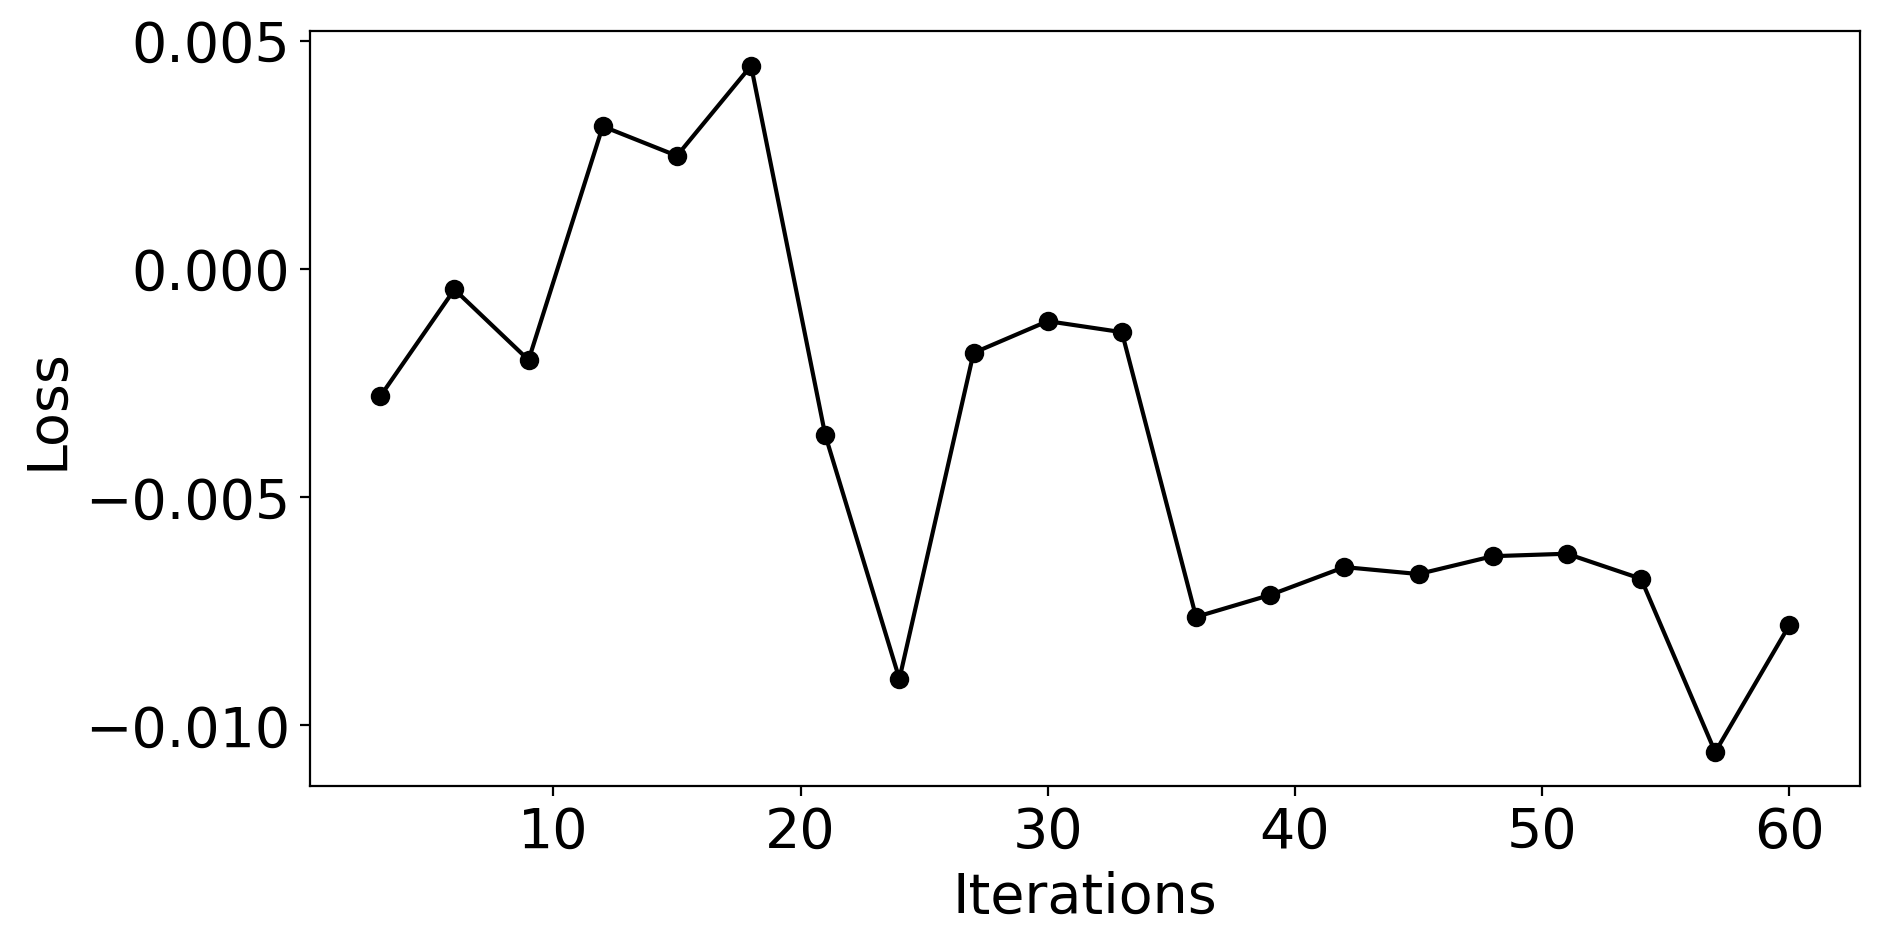

initial_point:  [77.27972722635425]
end loss:  -0.007803365058759686
--------------------------------
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]


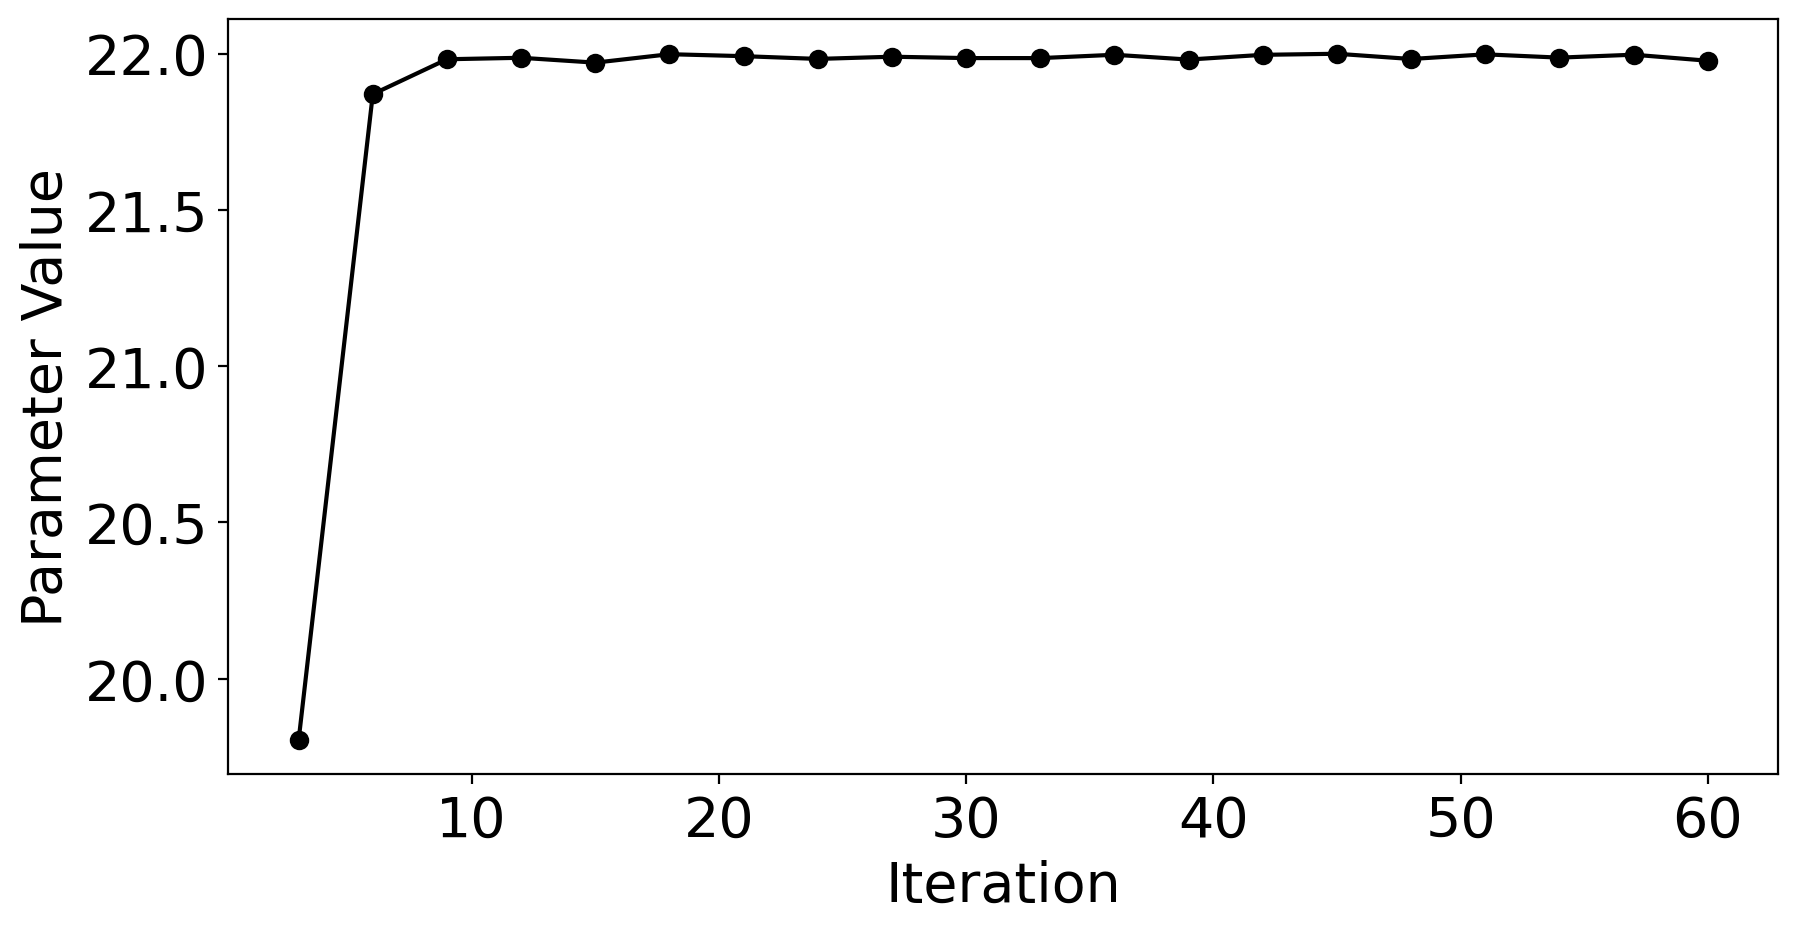

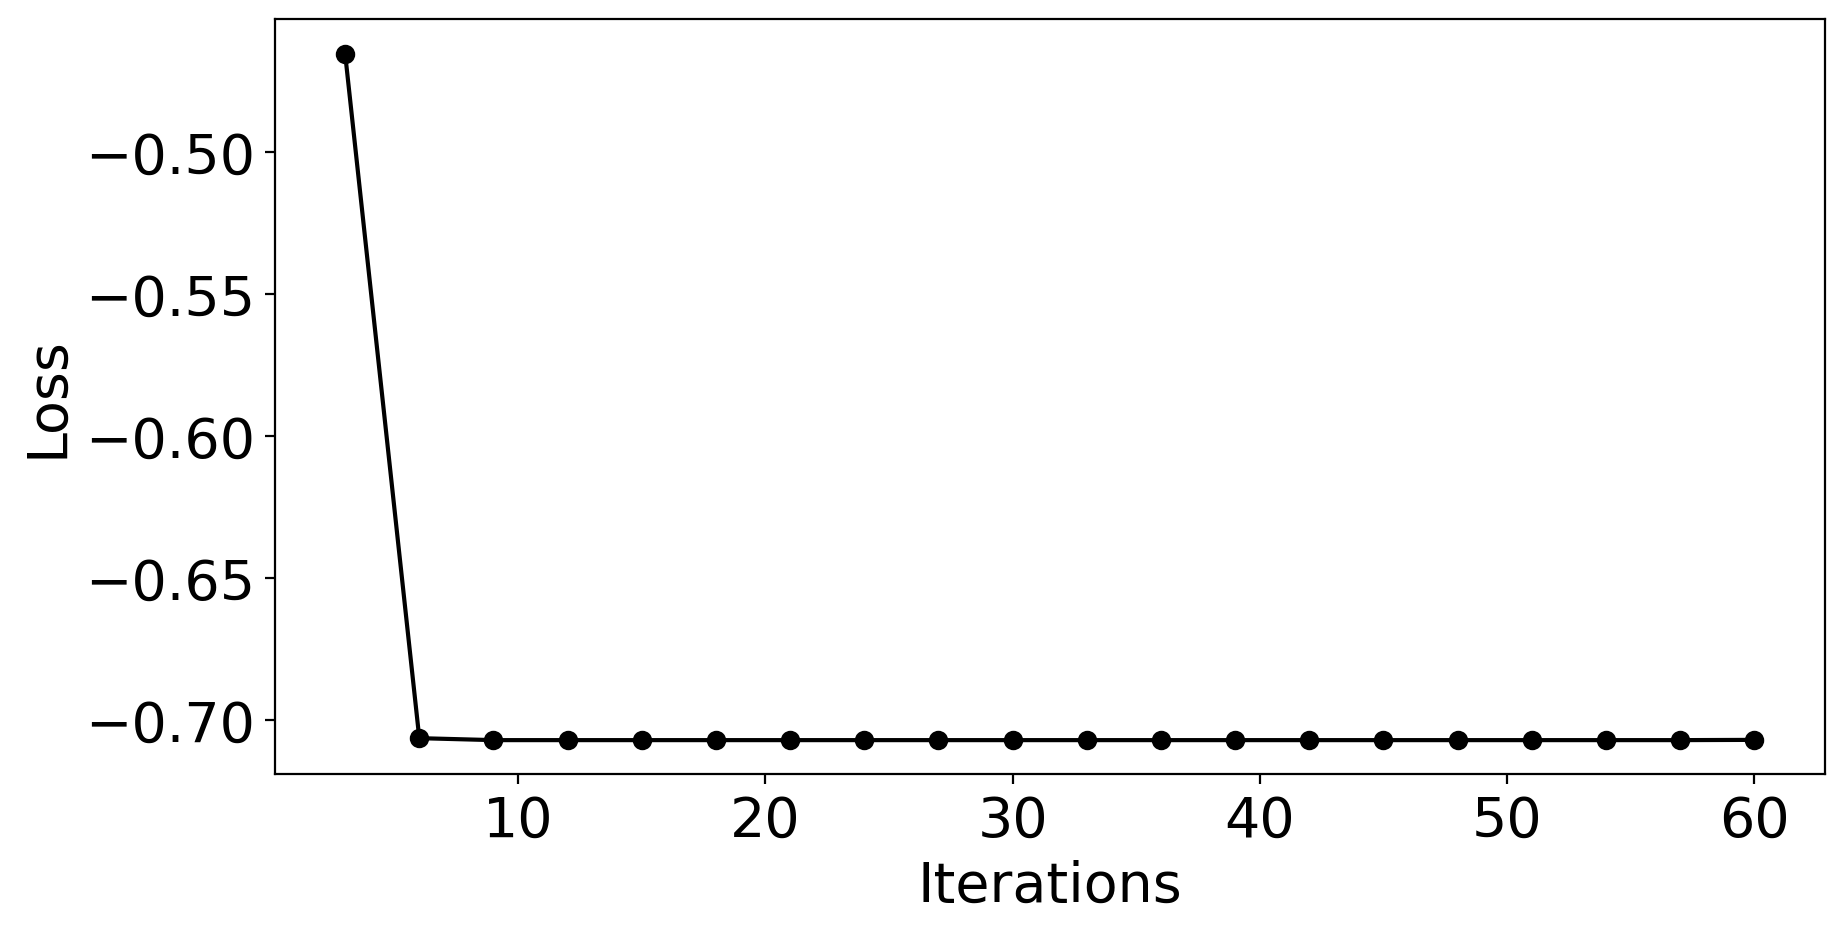

initial_point:  [18.249256626233034]
end loss:  -0.7070204222990973
--------------------------------
Best loss:  -0.7071067811865475


array([[1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1.]])

In [69]:
optimized_callback = run_SPSA_optimizations(runs= 10, show_loss_evolution=True, show_parameter_evolution=True)
optimized_param = get_best_parameter(optimized_callback)
get_kernel(x, phi_value=optimized_param)